---
title: Statistical analysis
description: Exploratory Data Analysis of Head Coaches and Match Results datasets
---

### Imports

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import polars as pl
import seaborn as sns
from scipy.stats import pearsonr

sns.set_theme(context="paper", style="ticks", palette="deep", color_codes=True)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 300

### Loading data

In [4]:
head_coach = (
    pl.read_csv(Path("./data/head_coach.csv"))
    .cast({"Appointed": pl.Date, "EndDate": pl.Date})
    .filter(pl.col("Tenure") <= 3000)
)

### General plotting function

In [5]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures


def prepare_data(data, x_value, y_value, degree=2):
    # Convert polars dataframe columns to numpy arrays
    x = data.get_column(x_value).to_numpy().reshape(-1, 1)
    y = data.get_column(y_value).to_numpy().flatten()
    polynomial_features = PolynomialFeatures(degree=degree)
    xp = polynomial_features.fit_transform(x)
    return xp, y, polynomial_features


def fit_model(xp, y):
    model = sm.OLS(y, xp)
    results = model.fit()
    return results


def create_predictions(results, polynomial_features, x_min, x_max):
    xs = np.linspace(x_min, x_max).reshape(-1, 1)
    xs = polynomial_features.transform(xs)
    ys = results.predict(xs)
    predictions = results.get_prediction(xs)
    ci = predictions.conf_int()
    return xs, ys, ci


def create_polynomial_regression_plot(
    data, x_value, y_value, y_leg, color, title, xlabel, degree=2, integer_ticks=False
):
    xp, y, polynomial_features = prepare_data(data, x_value, y_value, degree)
    results = fit_model(xp, y)
    xs, ys, ci = create_predictions(
        results,
        polynomial_features,
        data.get_column(x_value).min(),
        data.get_column(x_value).max(),
    )

    plt.figure()
    x_vals = data.get_column(x_value).to_numpy().flatten()
    y_vals = data.get_column(y_value).to_numpy().flatten()
    plt.scatter(x_vals, y_vals, color=color, alpha=0.2)
    (line,) = plt.plot(xs[:, 1], ys, color=color)
    plt.fill_between(xs[:, 1], ci[:, 0], ci[:, 1], color=color, alpha=0.3)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(f"{y_leg.capitalize()} percentage")
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))

    if integer_ticks:
        plt.xticks(np.arange(min(x_vals), max(x_vals) + 1, 1.0))

    r, p = pearsonr(x_vals, y_vals)
    plt.legend(
        [line, line],
        [
            f"Polynomial regression (degree {degree})",
            f"Pearson correlation : $r = {r:.2f}$, $p = {p:.2f}$",
        ],
        loc="upper right",
    )

#### Relation between Head Coaches appointments results and Head Coaches Tenure in Club

In [6]:
head_coach = head_coach.with_columns(
    (pl.col("Wins") / pl.col("Matches") * 100).alias("WinPercentage"),
    (pl.col("Draws") / pl.col("Matches") * 100).alias("DrawPercentage"),
    (pl.col("Losses") / pl.col("Matches") * 100).alias("LossPercentage"),
)

title = "{} Ratio of Head Coach Appointment versus Head Coach Appointment Tenure"
x_label = "Head Coach Appointment tenure (days)"

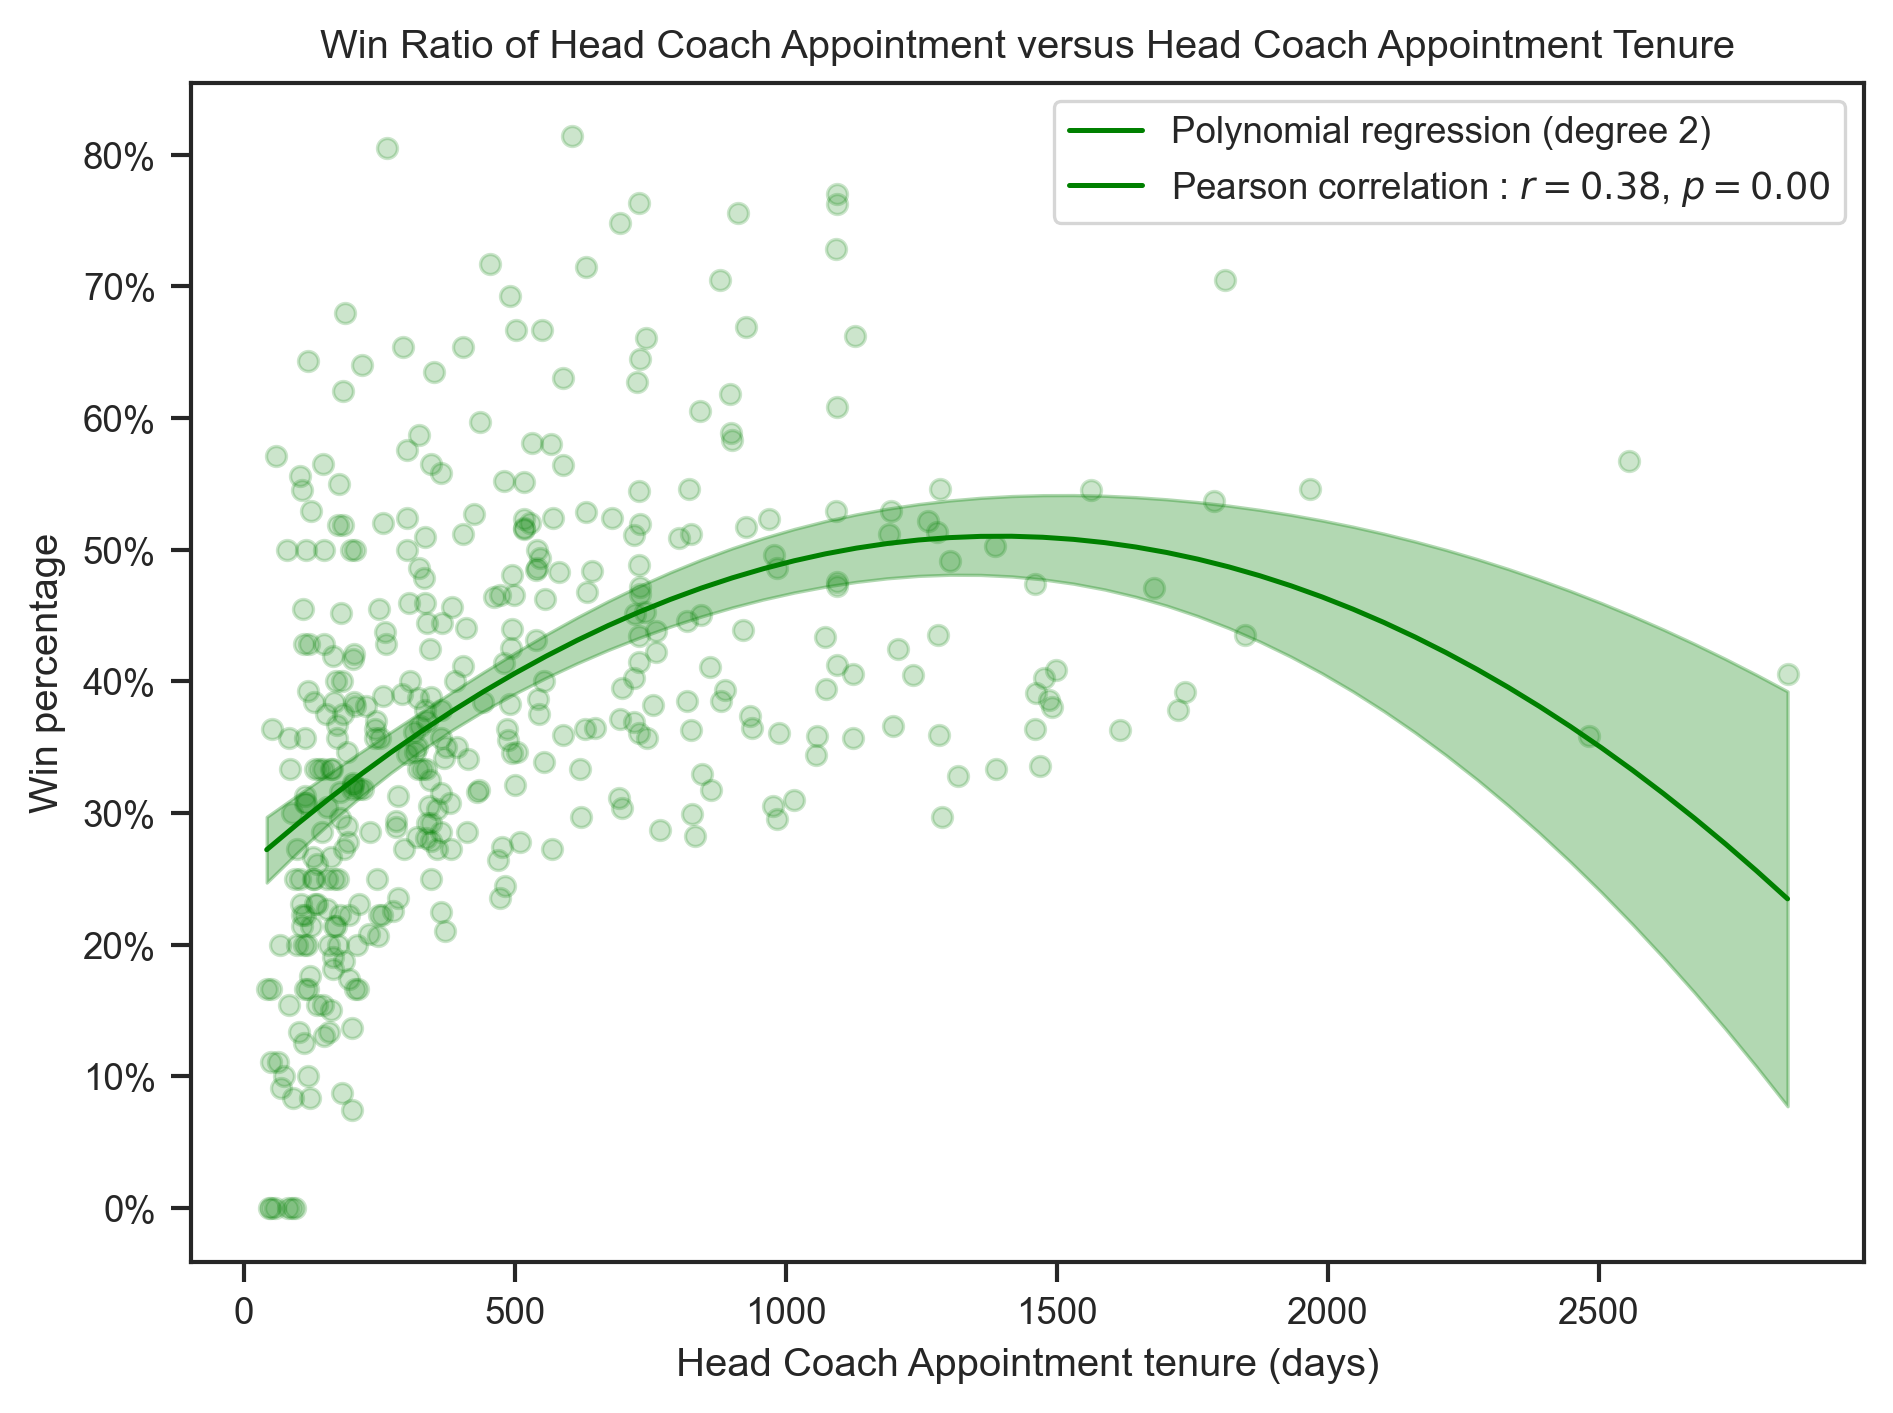

In [7]:
# | label: hc_win_ratio_over_days
create_polynomial_regression_plot(
    head_coach,
    "Tenure",
    "WinPercentage",
    "Win",
    "green",
    title.format("Win"),
    x_label,
    degree=2,
)

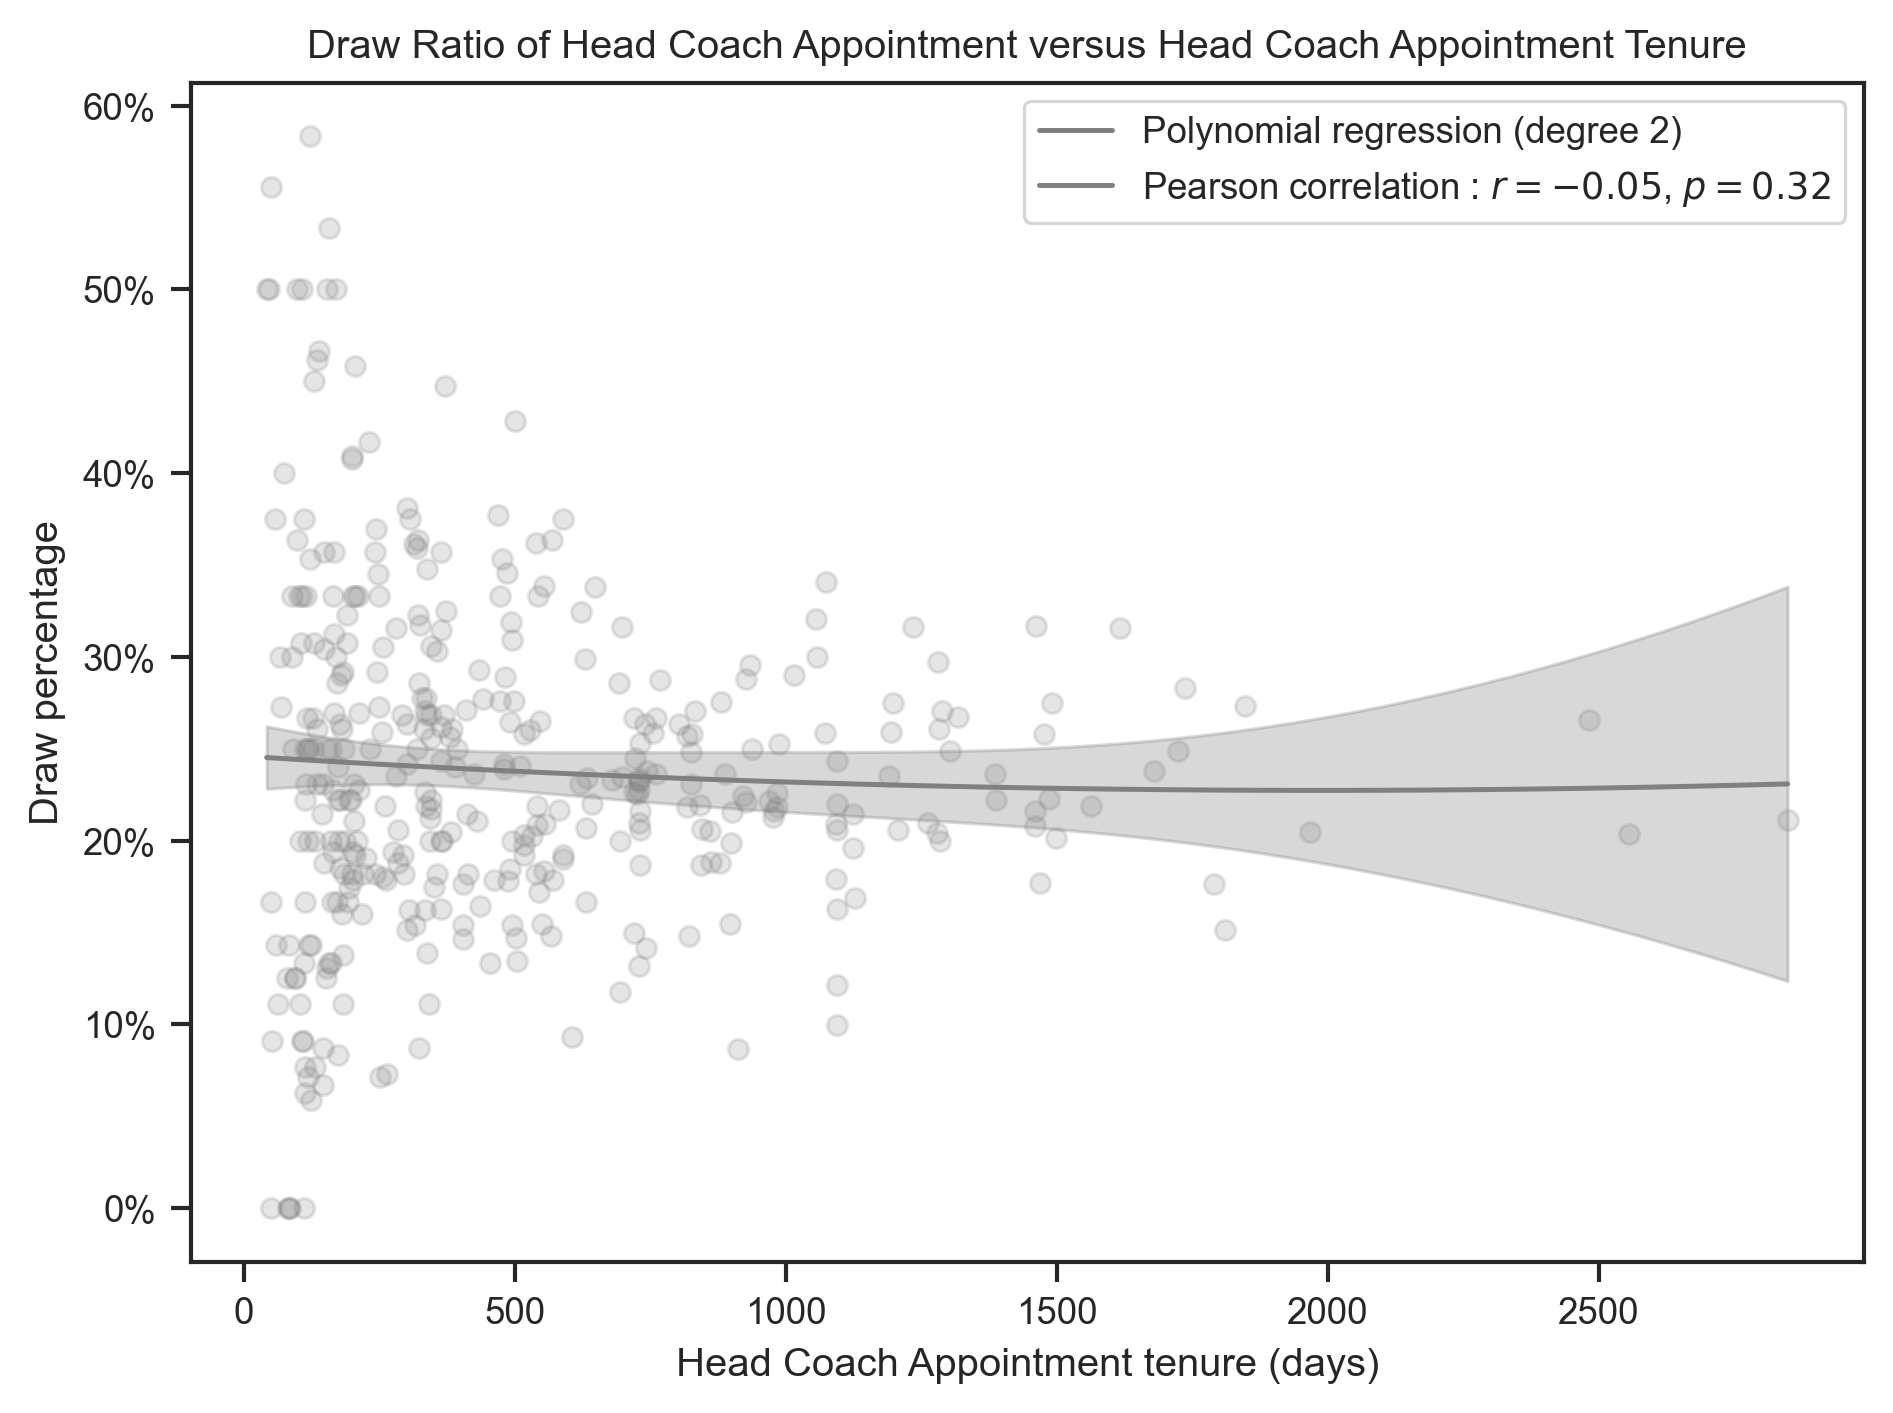

In [8]:
# | label: hc_draw_ratio_over_days
create_polynomial_regression_plot(
    head_coach,
    "Tenure",
    "DrawPercentage",
    "Draw",
    "gray",
    title.format("Draw"),
    x_label,
    degree=2,
)

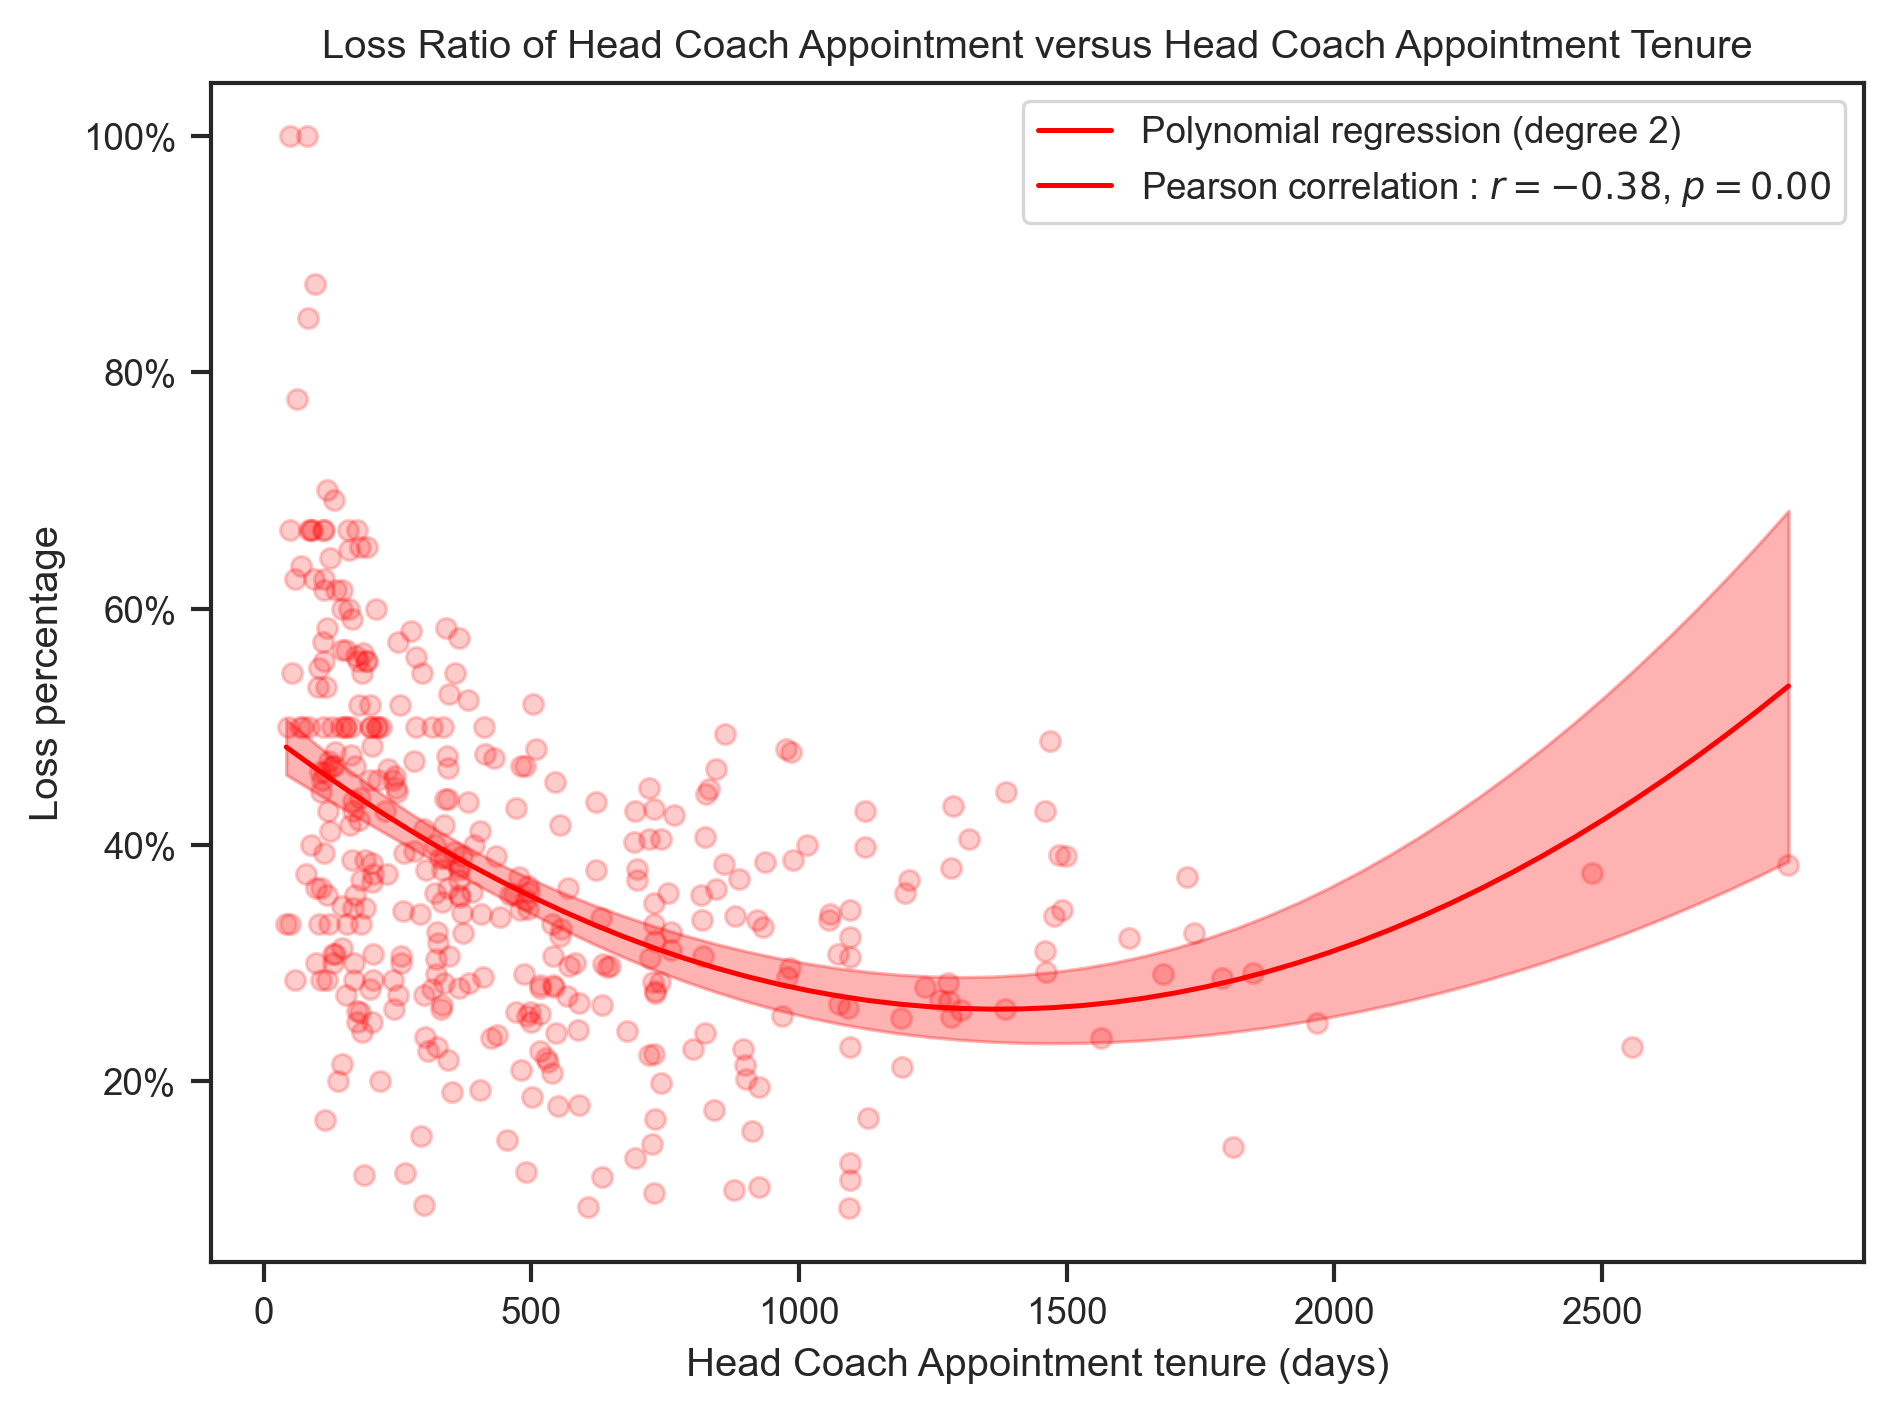

In [9]:
# | label: hc_loss_ratio_over_days
create_polynomial_regression_plot(
    head_coach,
    "Tenure",
    "LossPercentage",
    "Loss",
    "red",
    title.format("Loss"),
    x_label,
    degree=2,
)

#### Relation between Clubs Results and Number of Head Coaches

In [10]:
club_results = (
    head_coach.group_by("Team")
    .agg(
        pl.col("Wins").sum(),
        pl.col("Draws").sum(),
        pl.col("Losses").sum(),
        pl.col("Matches").sum(),
        pl.col("HeadCoach").count().alias("CoachCount"),
    )
    .with_columns(
        (pl.col("Wins") / pl.col("Matches") * 100).alias("WinPercentage"),
        (pl.col("Draws") / pl.col("Matches") * 100).alias("DrawPercentage"),
        (pl.col("Losses") / pl.col("Matches") * 100).alias("LossPercentage"),
    )
)

title = "{} Ratio of Clubs versus Number of Head Coaches Appointment (2015-2023)"
x_label = "Number of Head Coach Appointment per Club"

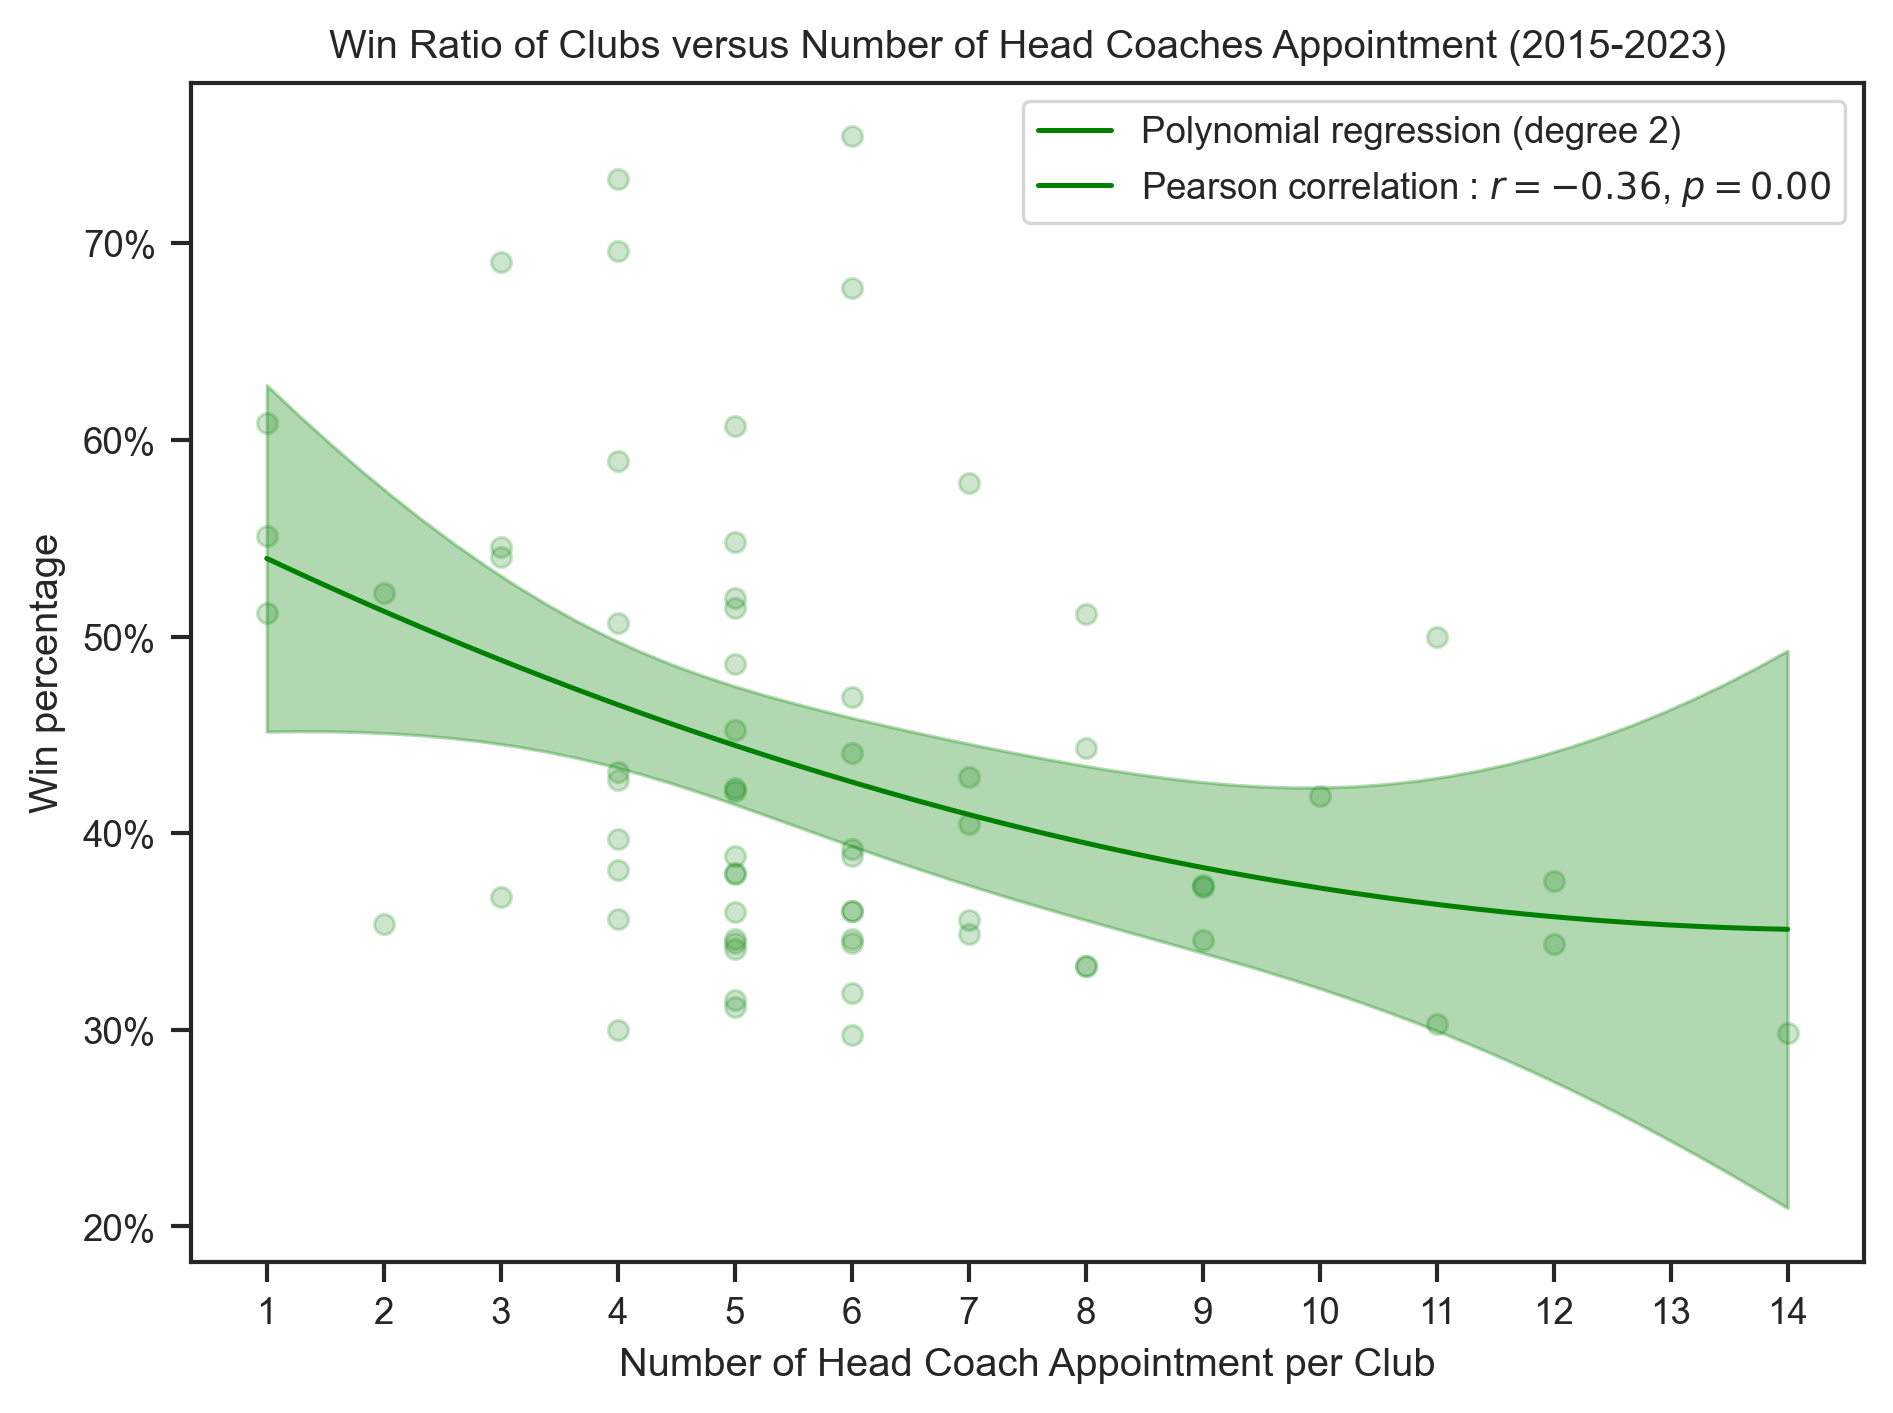

In [11]:
# | label: club_win_ratio_over_coach_count
create_polynomial_regression_plot(
    club_results,
    "CoachCount",
    "WinPercentage",
    "Win",
    "green",
    title.format("Win"),
    x_label,
    degree=2,
    integer_ticks=True,
)

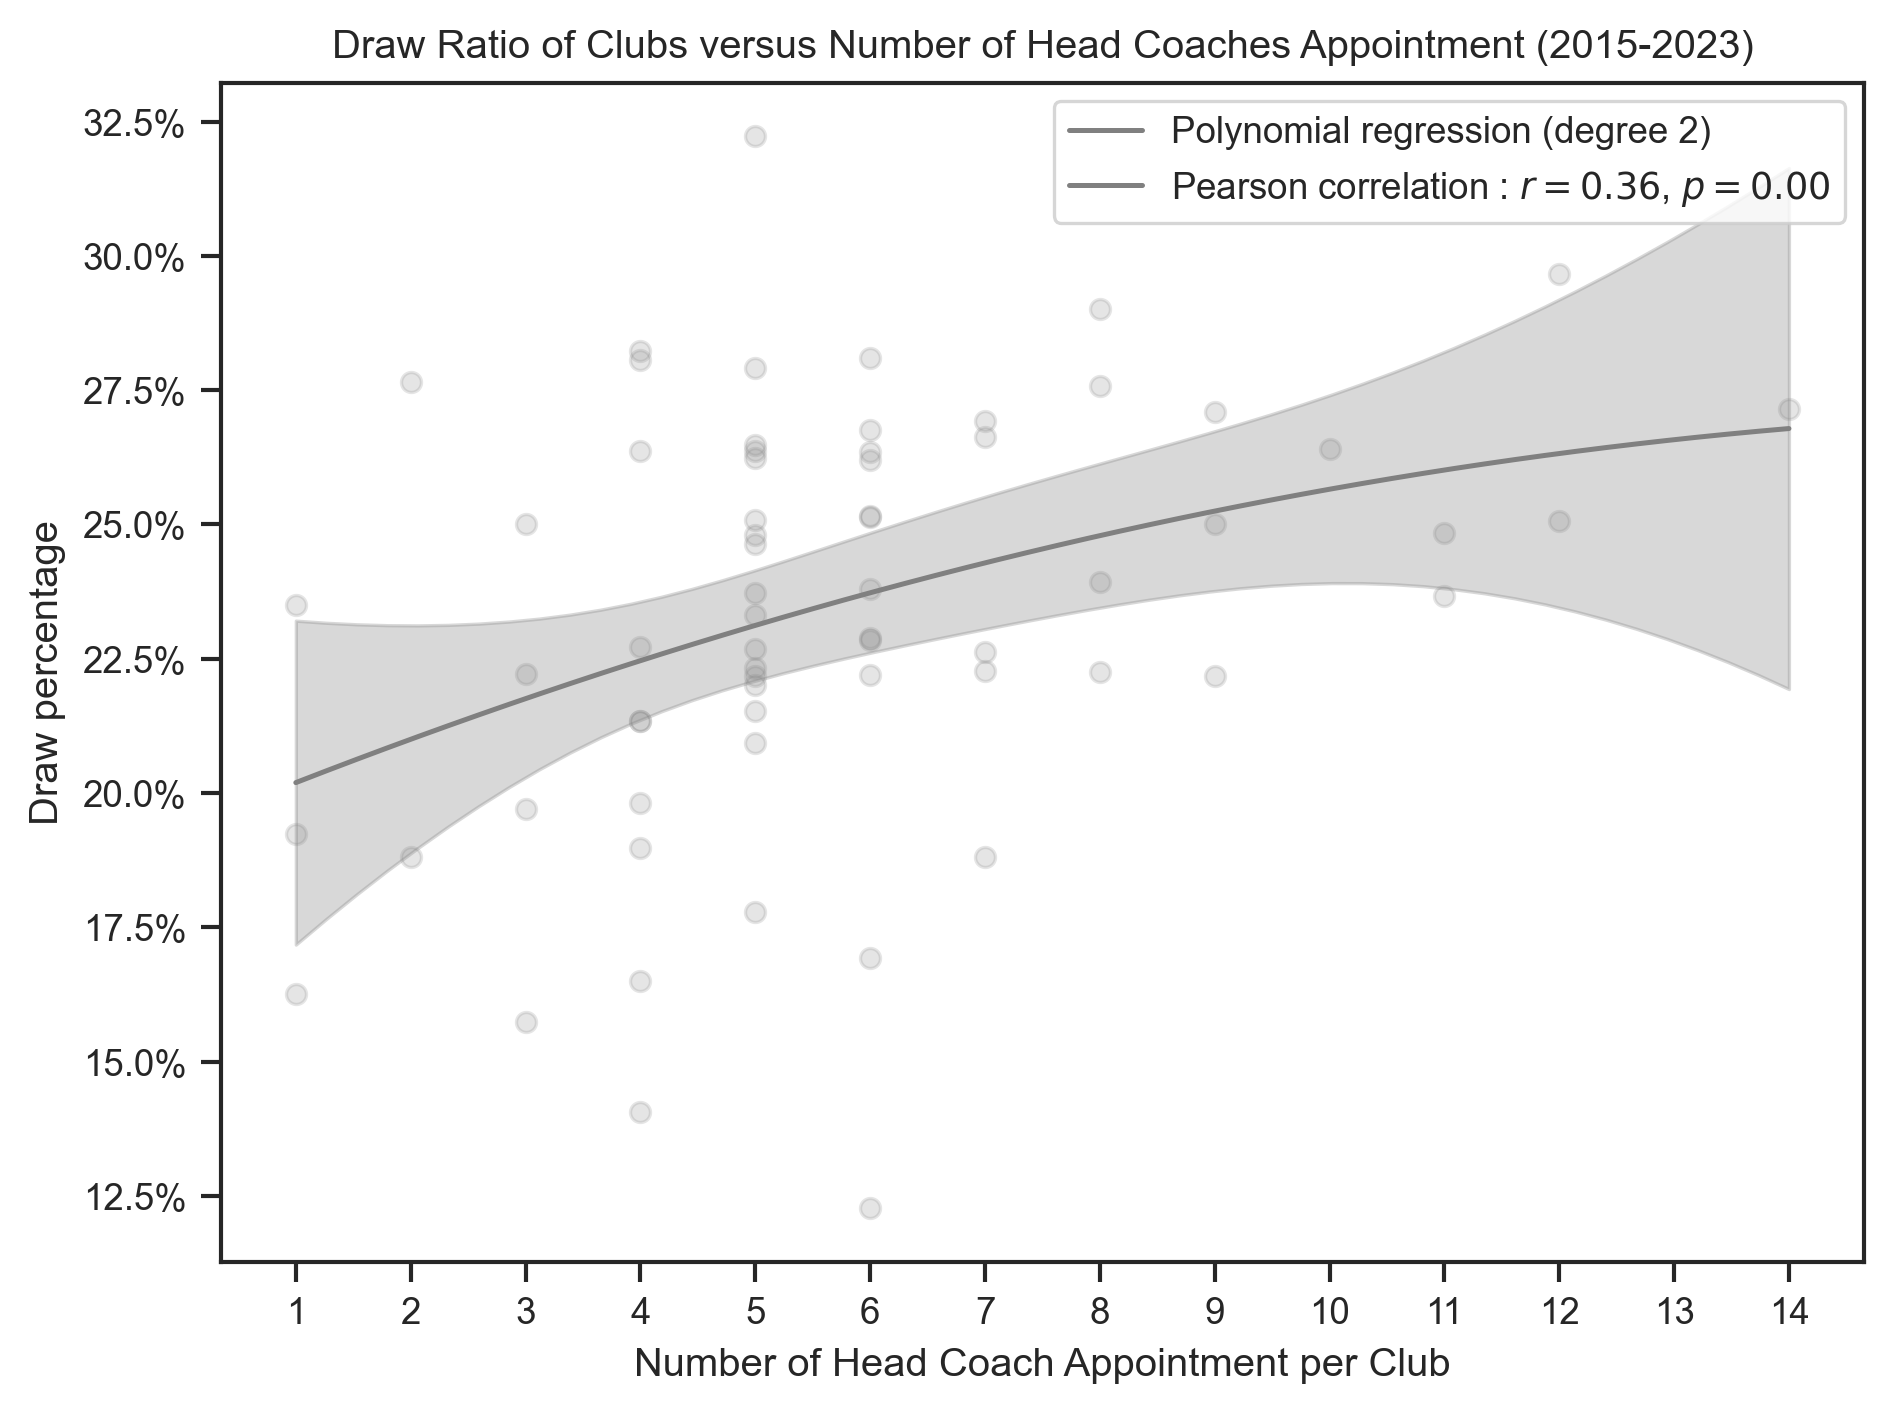

In [12]:
# | label: club_draw_ratio_over_coach_count
create_polynomial_regression_plot(
    club_results,
    "CoachCount",
    "DrawPercentage",
    "Draw",
    "gray",
    title.format("Draw"),
    x_label,
    degree=2,
    integer_ticks=True,
)

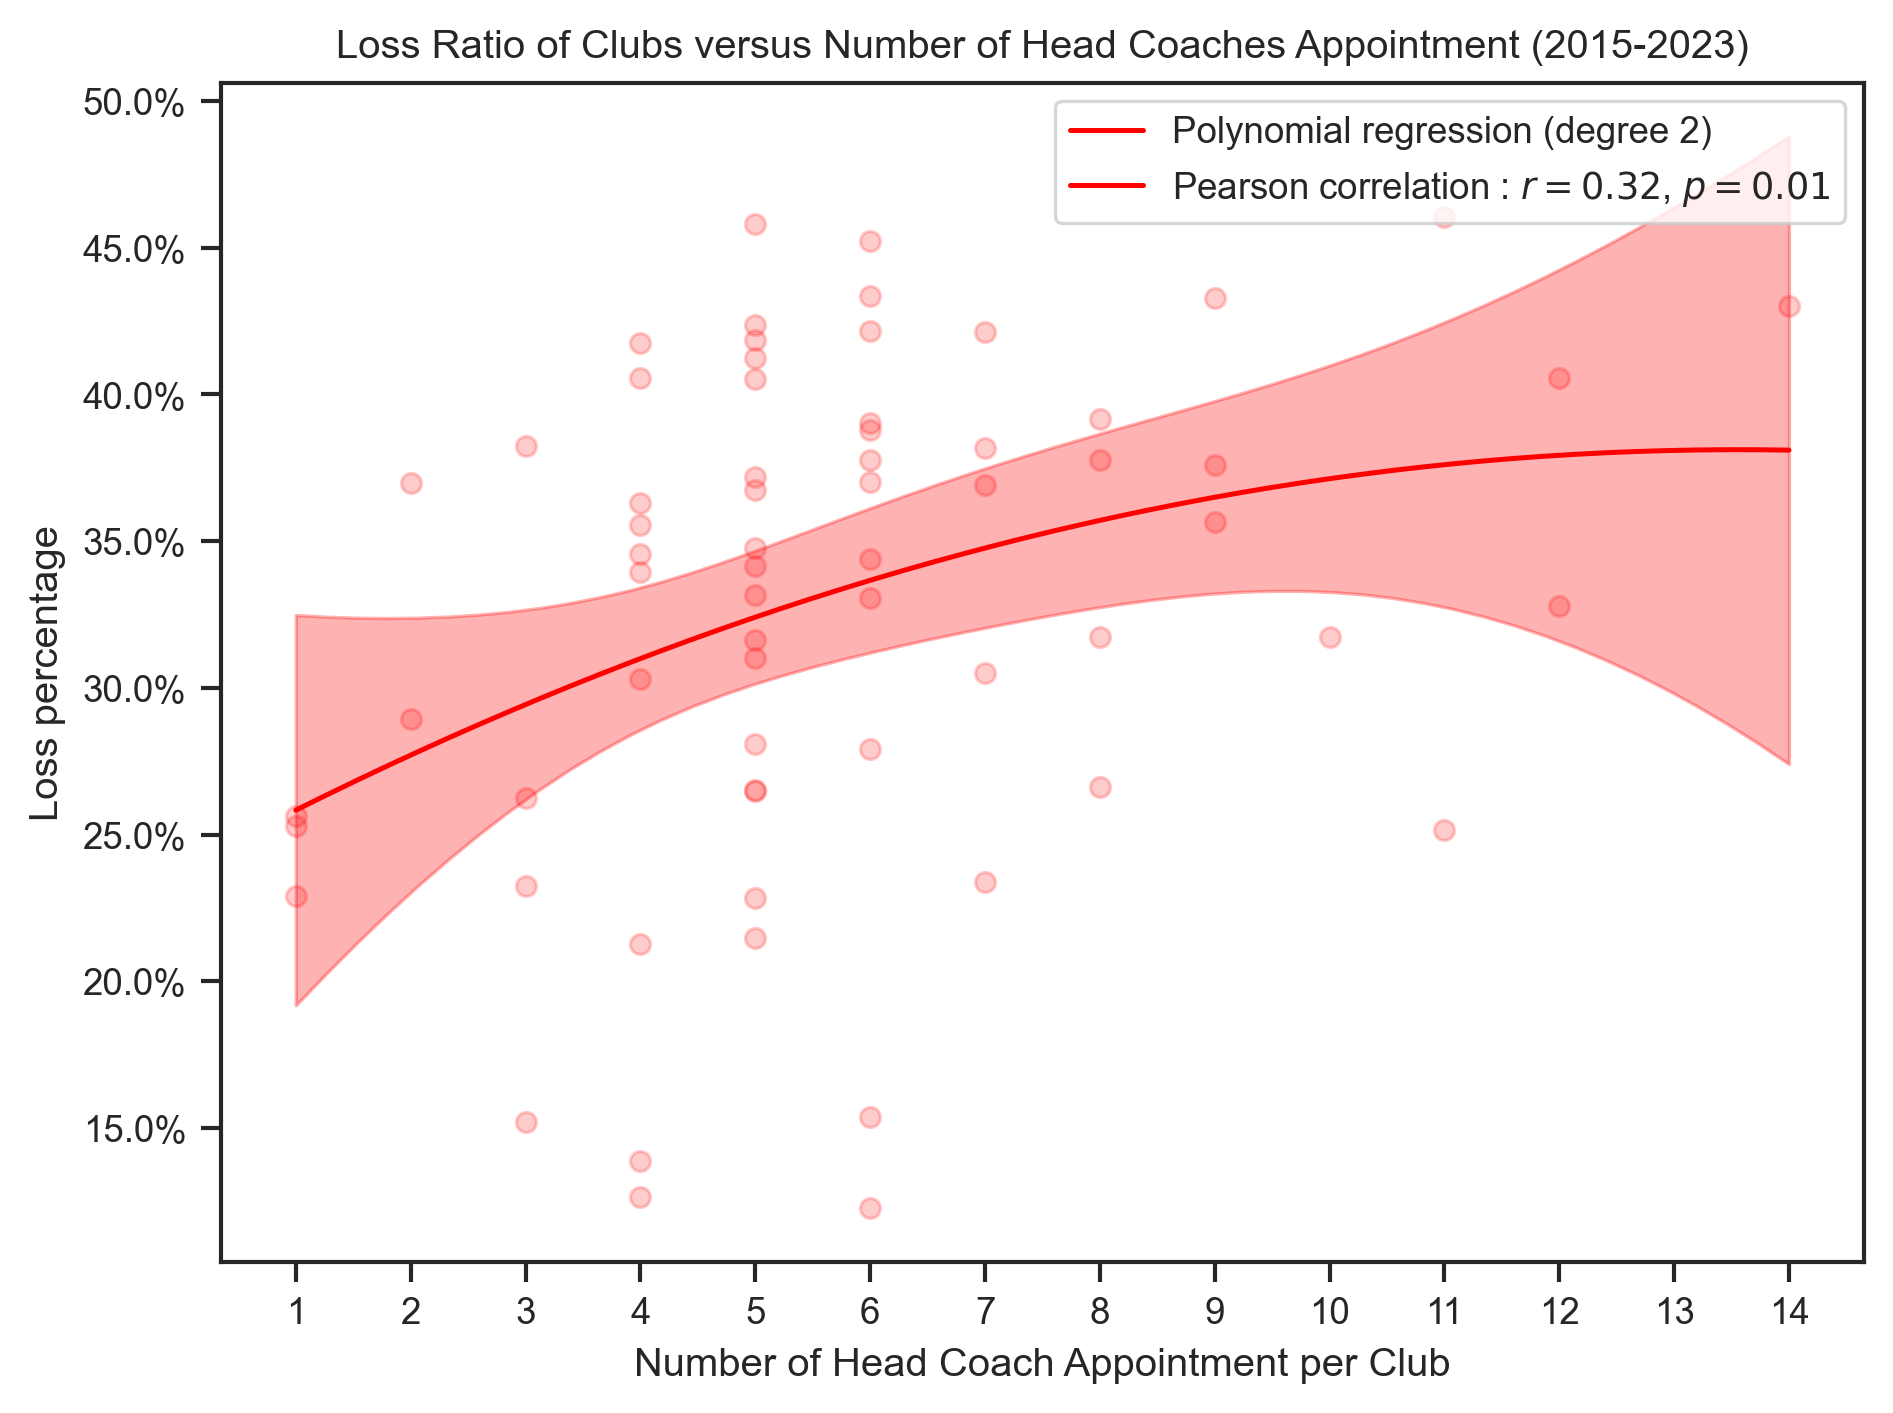

In [13]:
# | label: club_loss_ratio_over_coach_count
create_polynomial_regression_plot(
    club_results,
    "CoachCount",
    "LossPercentage",
    "Loss",
    "red",
    title.format("Loss"),
    x_label,
    degree=2,
    integer_ticks=True,
)

#### Relation between Head Coach Aggregated Performance versus Total Number of Clubs Head Coaches Worked for

In [14]:
# Plot of wins, draw and losses percentage over number of club head coach has been

hc_results = (
    head_coach.group_by("HeadCoach")
    .agg(
        pl.col("Matches").sum(),
        pl.col("Wins").sum(),
        pl.col("Draws").sum(),
        pl.col("Losses").sum(),
        pl.col("Team").count().alias("ClubCount"),
    )
    .with_columns(
        (pl.col("Wins") / pl.col("Matches") * 100).alias("WinPercentage"),
        (pl.col("Draws") / pl.col("Matches") * 100).alias("DrawPercentage"),
        (pl.col("Losses") / pl.col("Matches") * 100).alias("LossPercentage"),
    )
)

title = (
    "{} Ratio of Head Coach Career versus Number of Head Coach Appointments (2015-2023)"
)
x_label = "Number of Head Coach Appointments"

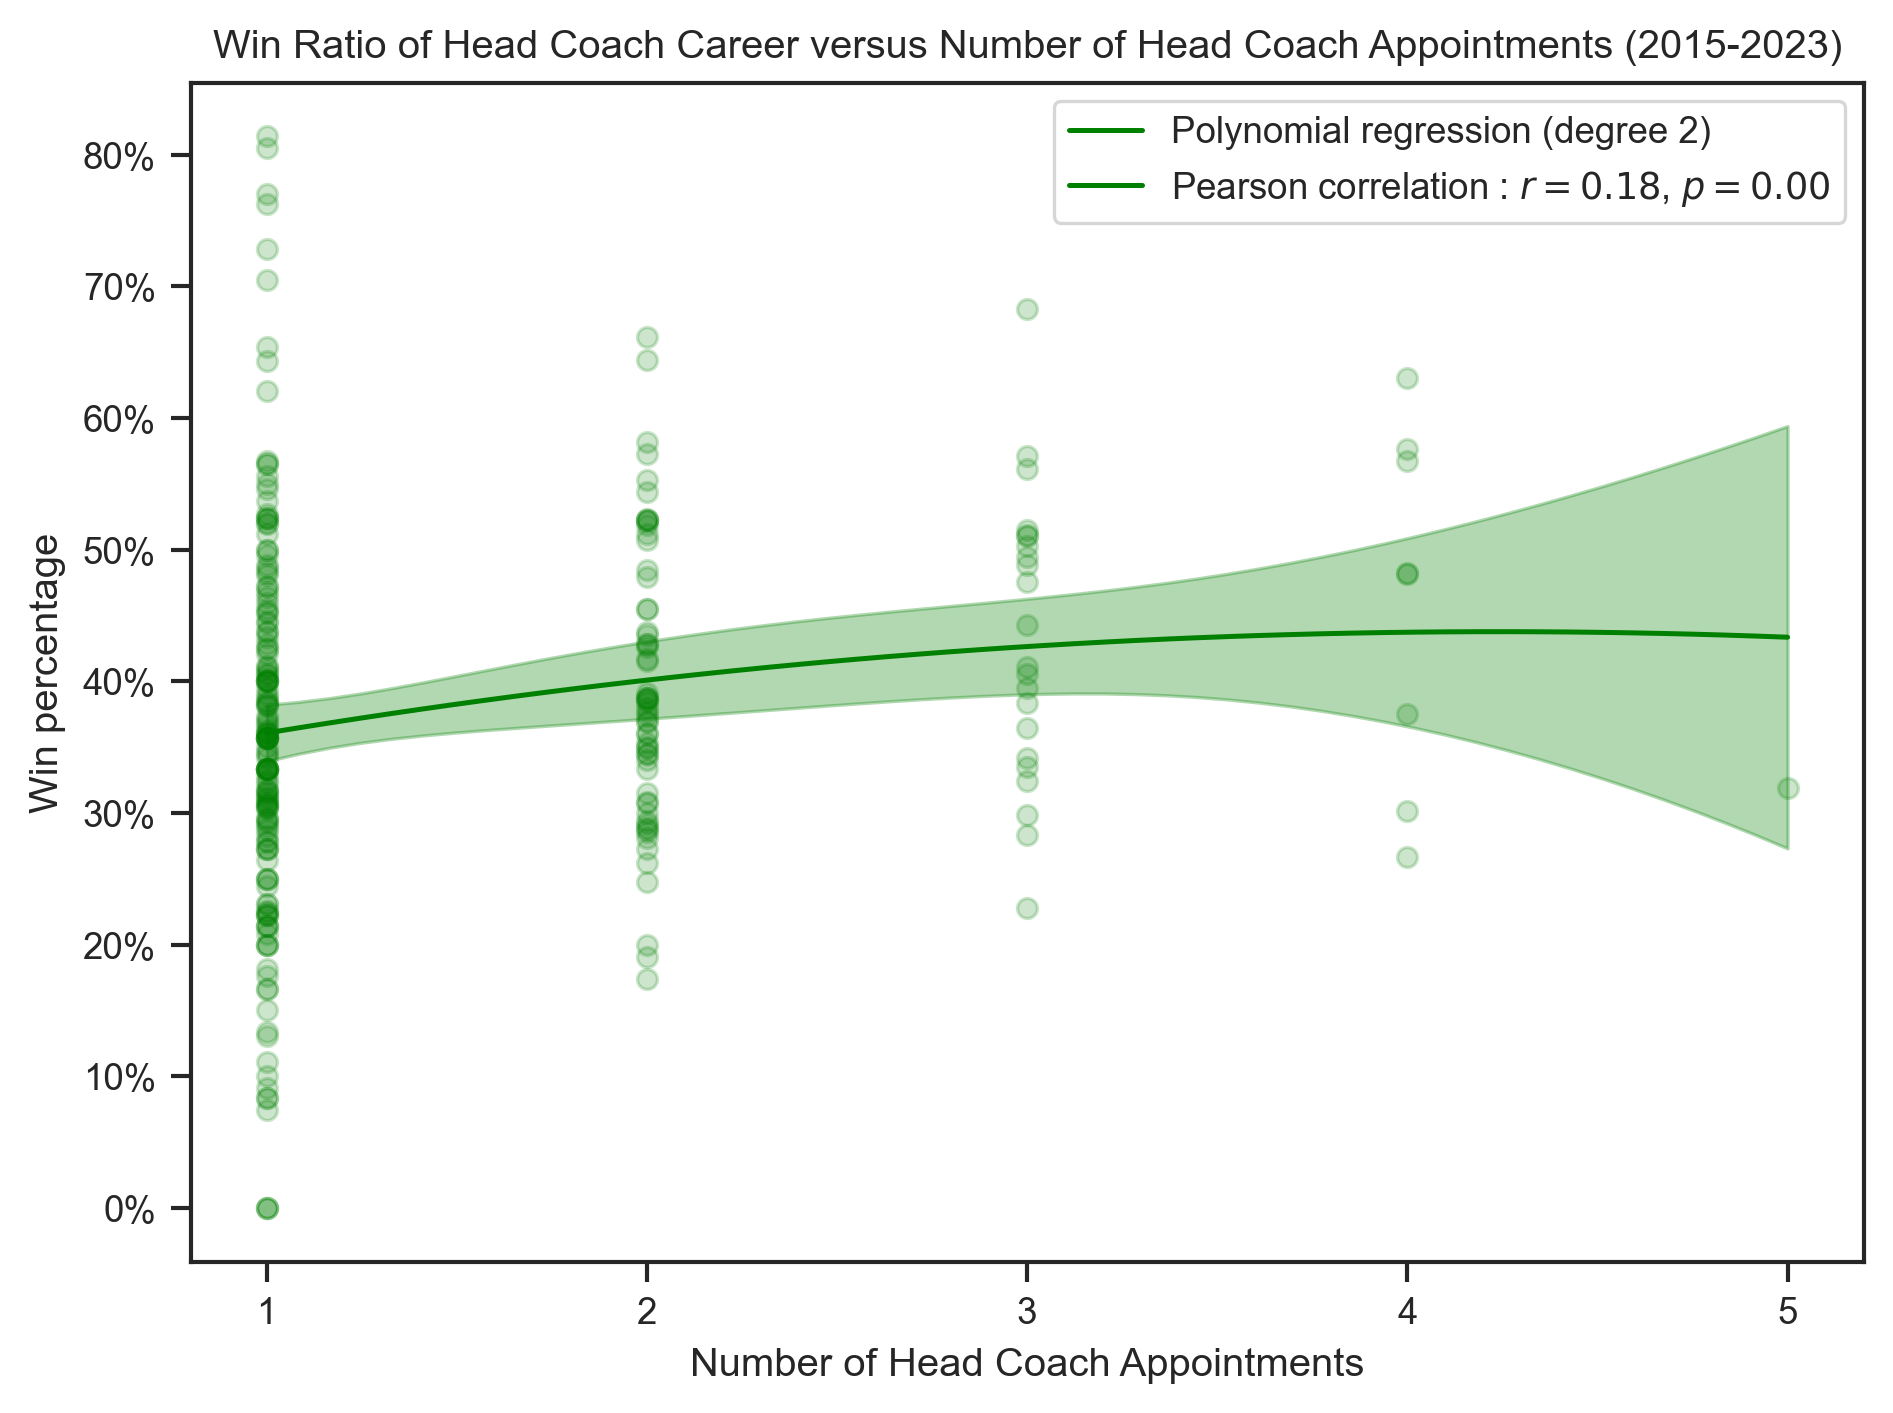

In [15]:
# | label: hc_win_ratio_over_club_count
create_polynomial_regression_plot(
    hc_results,
    "ClubCount",
    "WinPercentage",
    "Win",
    "green",
    title.format("Win"),
    x_label,
    degree=2,
    integer_ticks=True,
)

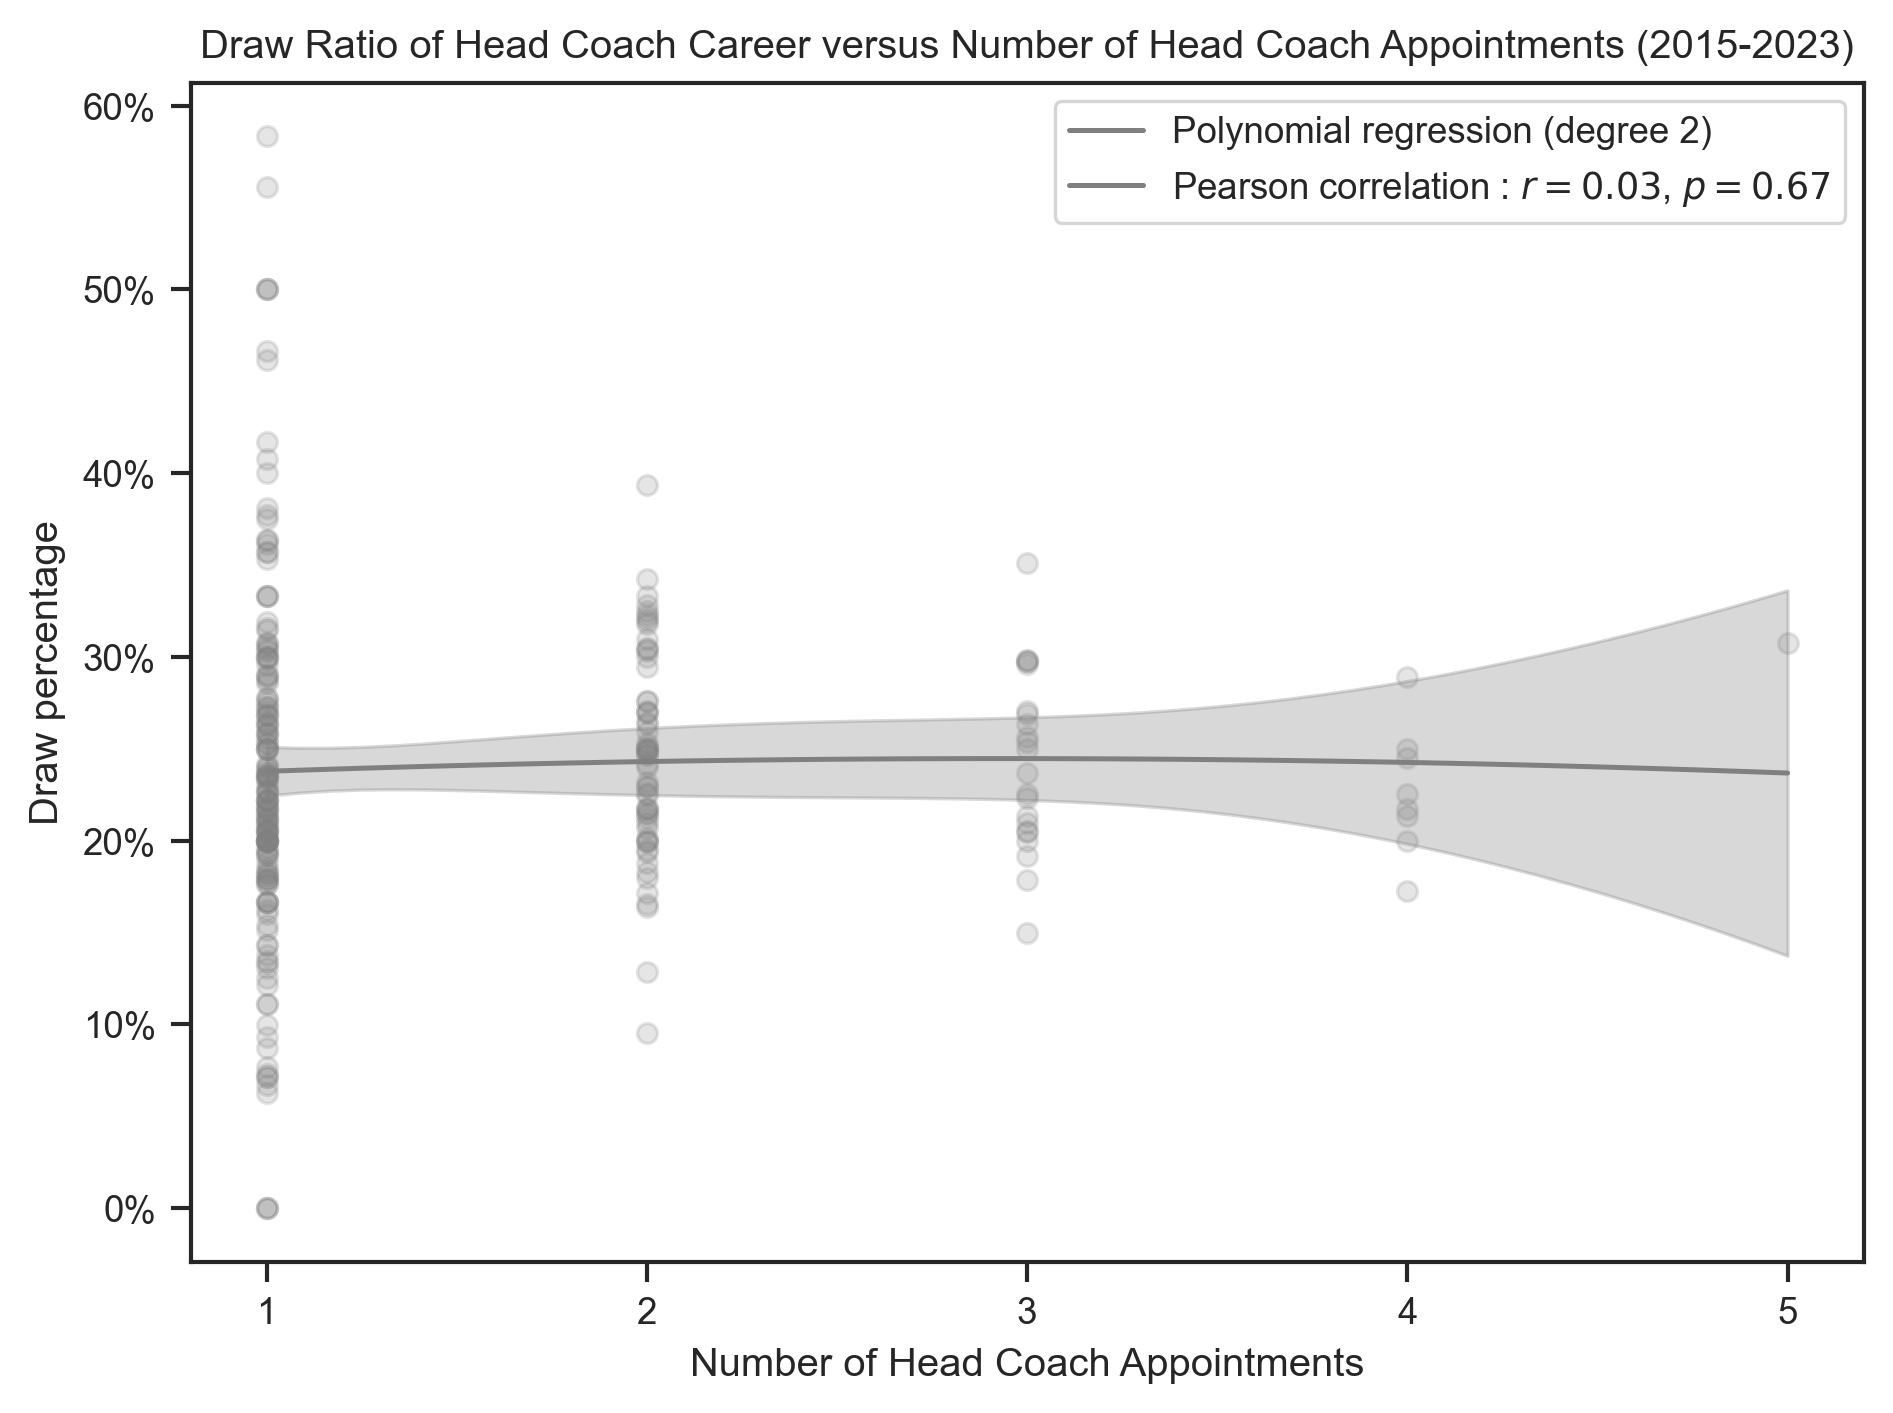

In [16]:
# | label: hc_draw_ratio_over_club_count
create_polynomial_regression_plot(
    hc_results,
    "ClubCount",
    "DrawPercentage",
    "Draw",
    "gray",
    title.format("Draw"),
    x_label,
    degree=2,
    integer_ticks=True,
)

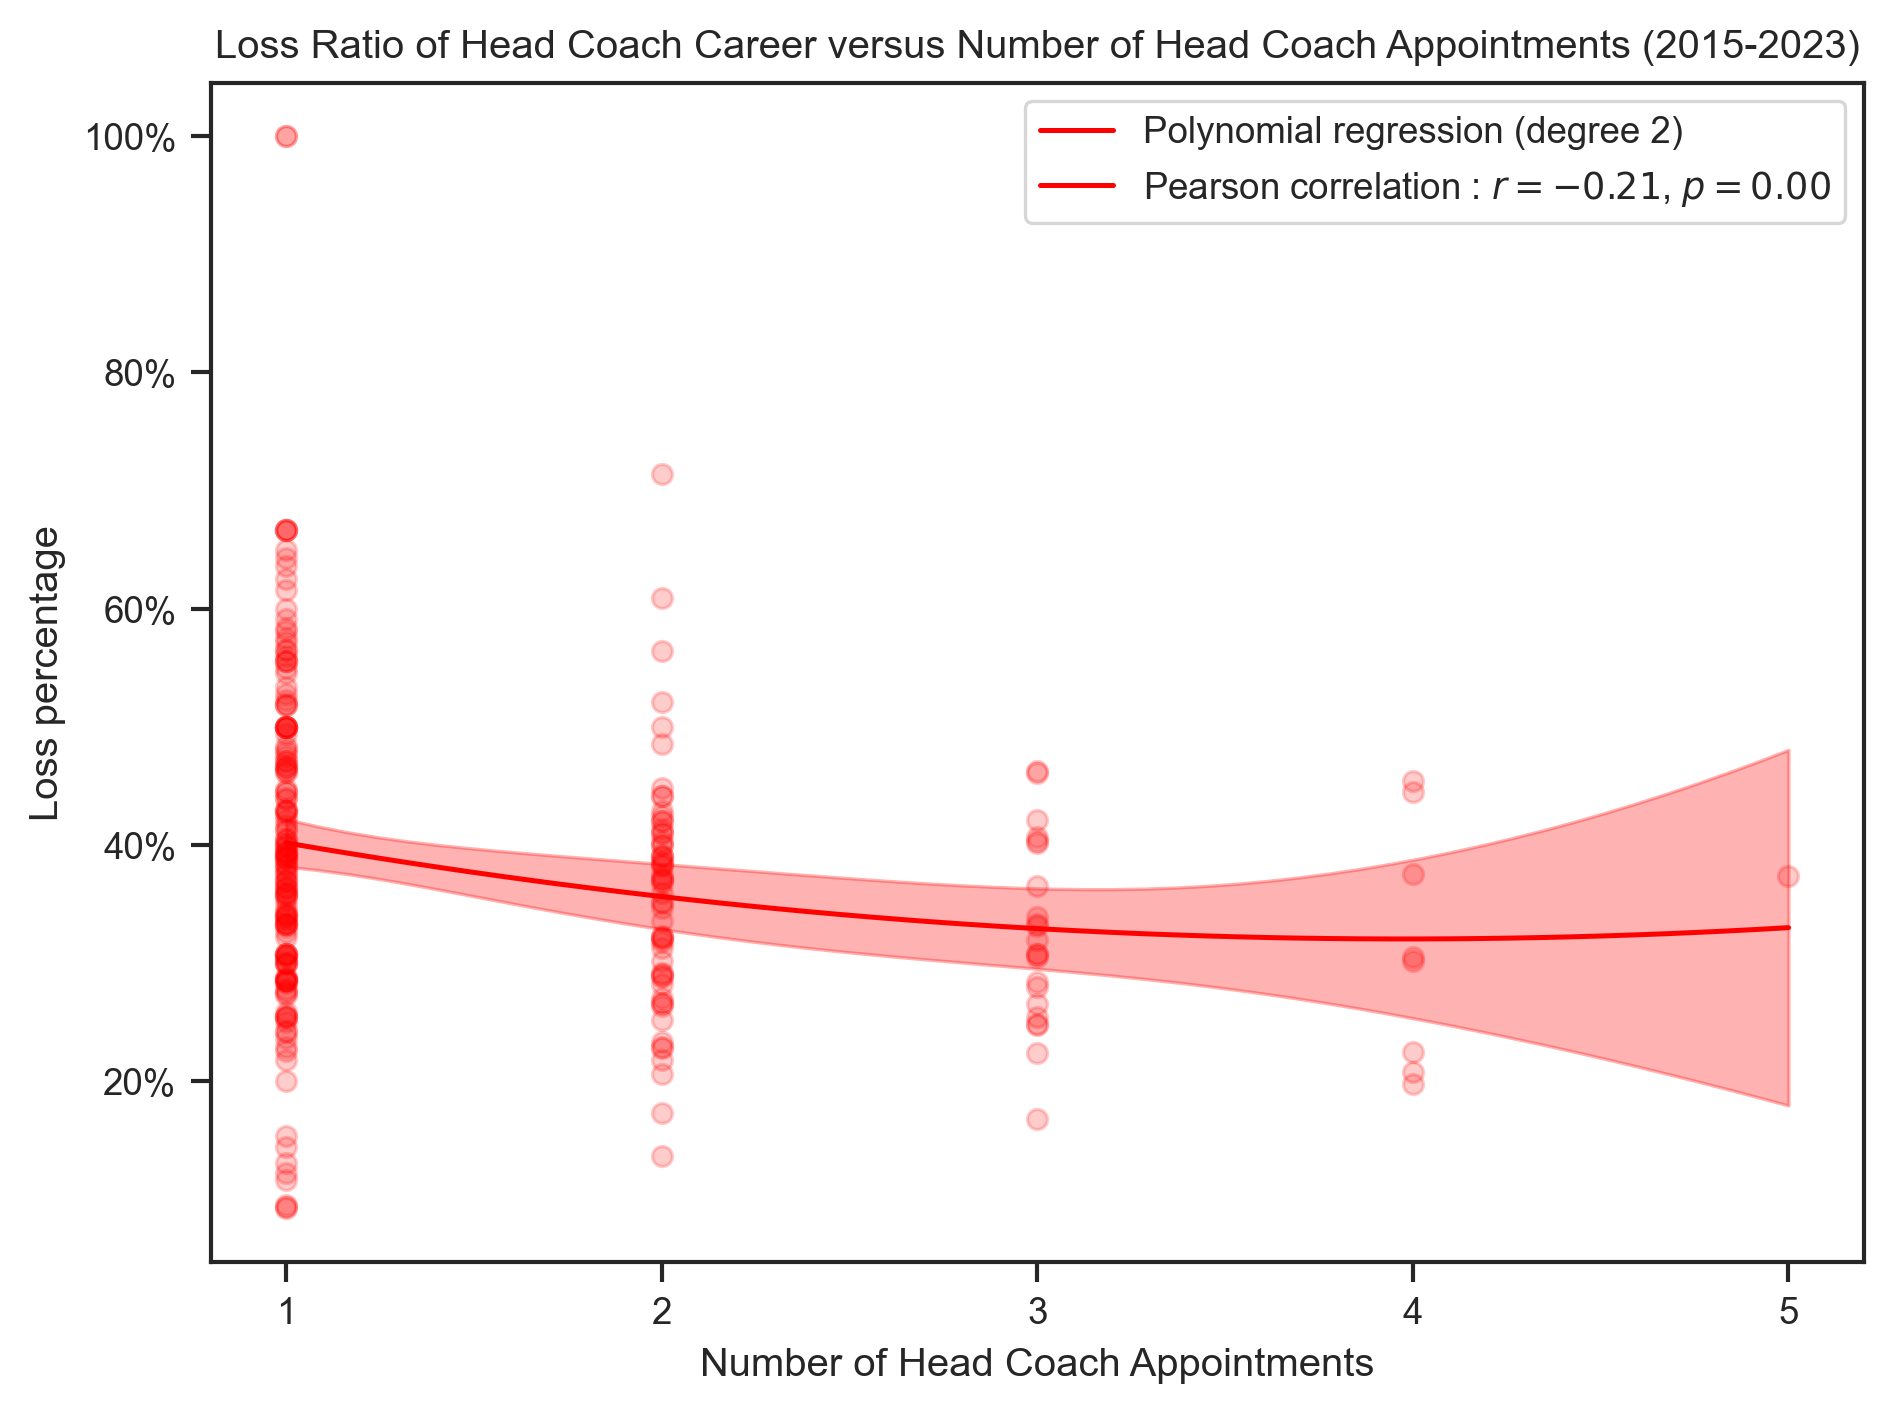

In [17]:
# | label: hc_loss_ratio_over_club_count
create_polynomial_regression_plot(
    hc_results,
    "ClubCount",
    "LossPercentage",
    "Loss",
    "red",
    title.format("Loss"),
    x_label,
    degree=2,
    integer_ticks=True,
)

#### Relation between Head Coach Appointments Results versus Head Coach Appointments Counts

In [18]:
title = "{} Ratio of Head Coaches Appointments versus Head Coach Appointment Count (2015-2023)"
x_label = "Head Coach Appointment Count"

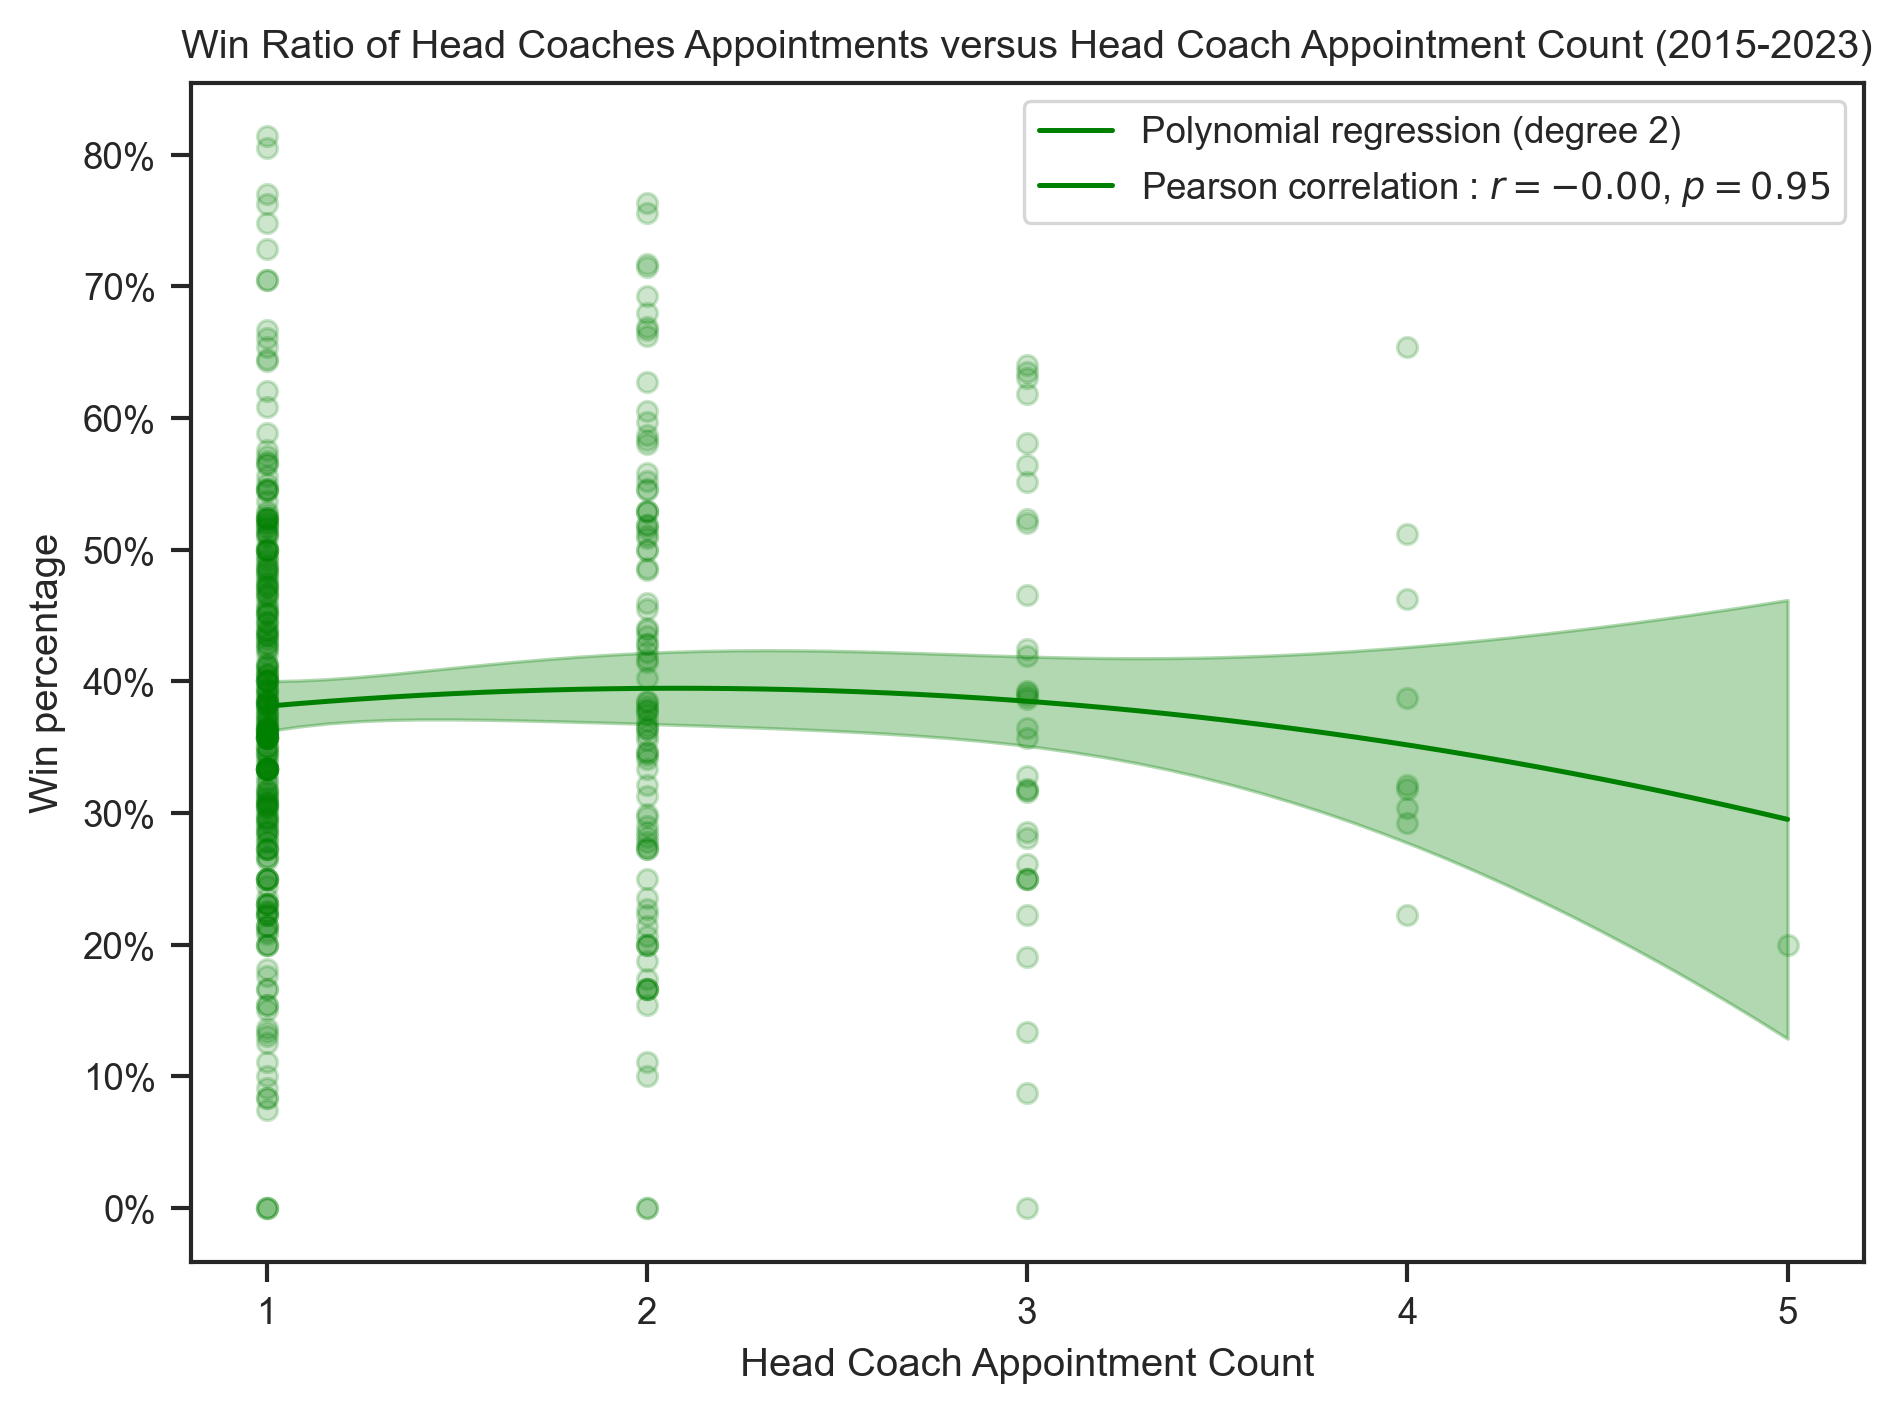

In [19]:
# | label: hc_win_vs_appointment_count
create_polynomial_regression_plot(
    head_coach,
    "AppointmentNumber",
    "WinPercentage",
    "Win",
    "green",
    title.format("Win"),
    x_label,
    degree=2,
    integer_ticks=True,
)

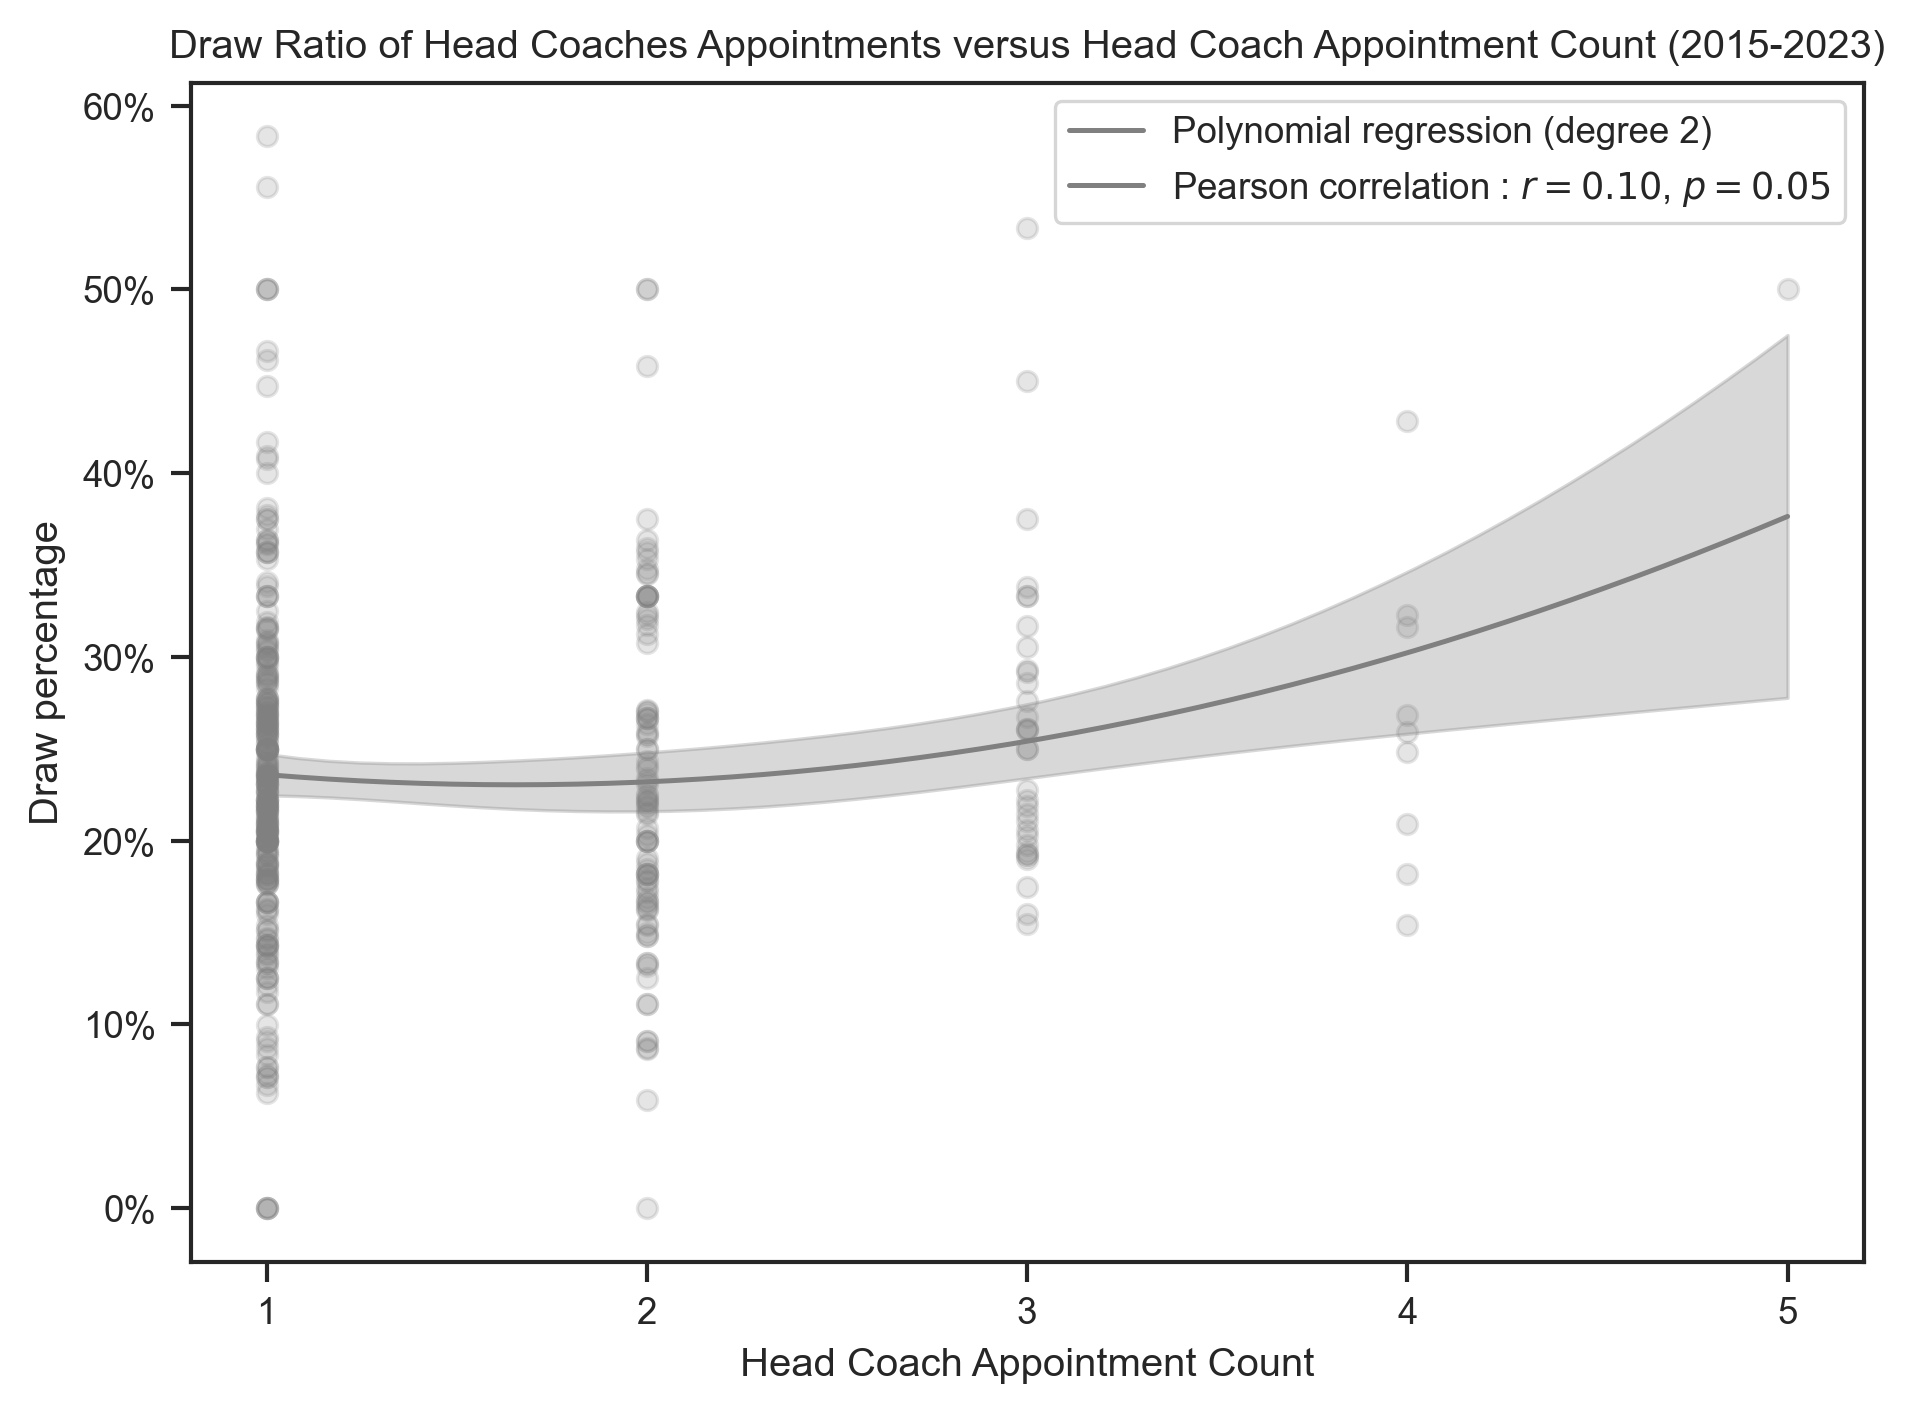

In [20]:
# | label: hc_draw_vs_appointment_count
create_polynomial_regression_plot(
    head_coach,
    "AppointmentNumber",
    "DrawPercentage",
    "Draw",
    "gray",
    title.format("Draw"),
    x_label,
    degree=2,
    integer_ticks=True,
)

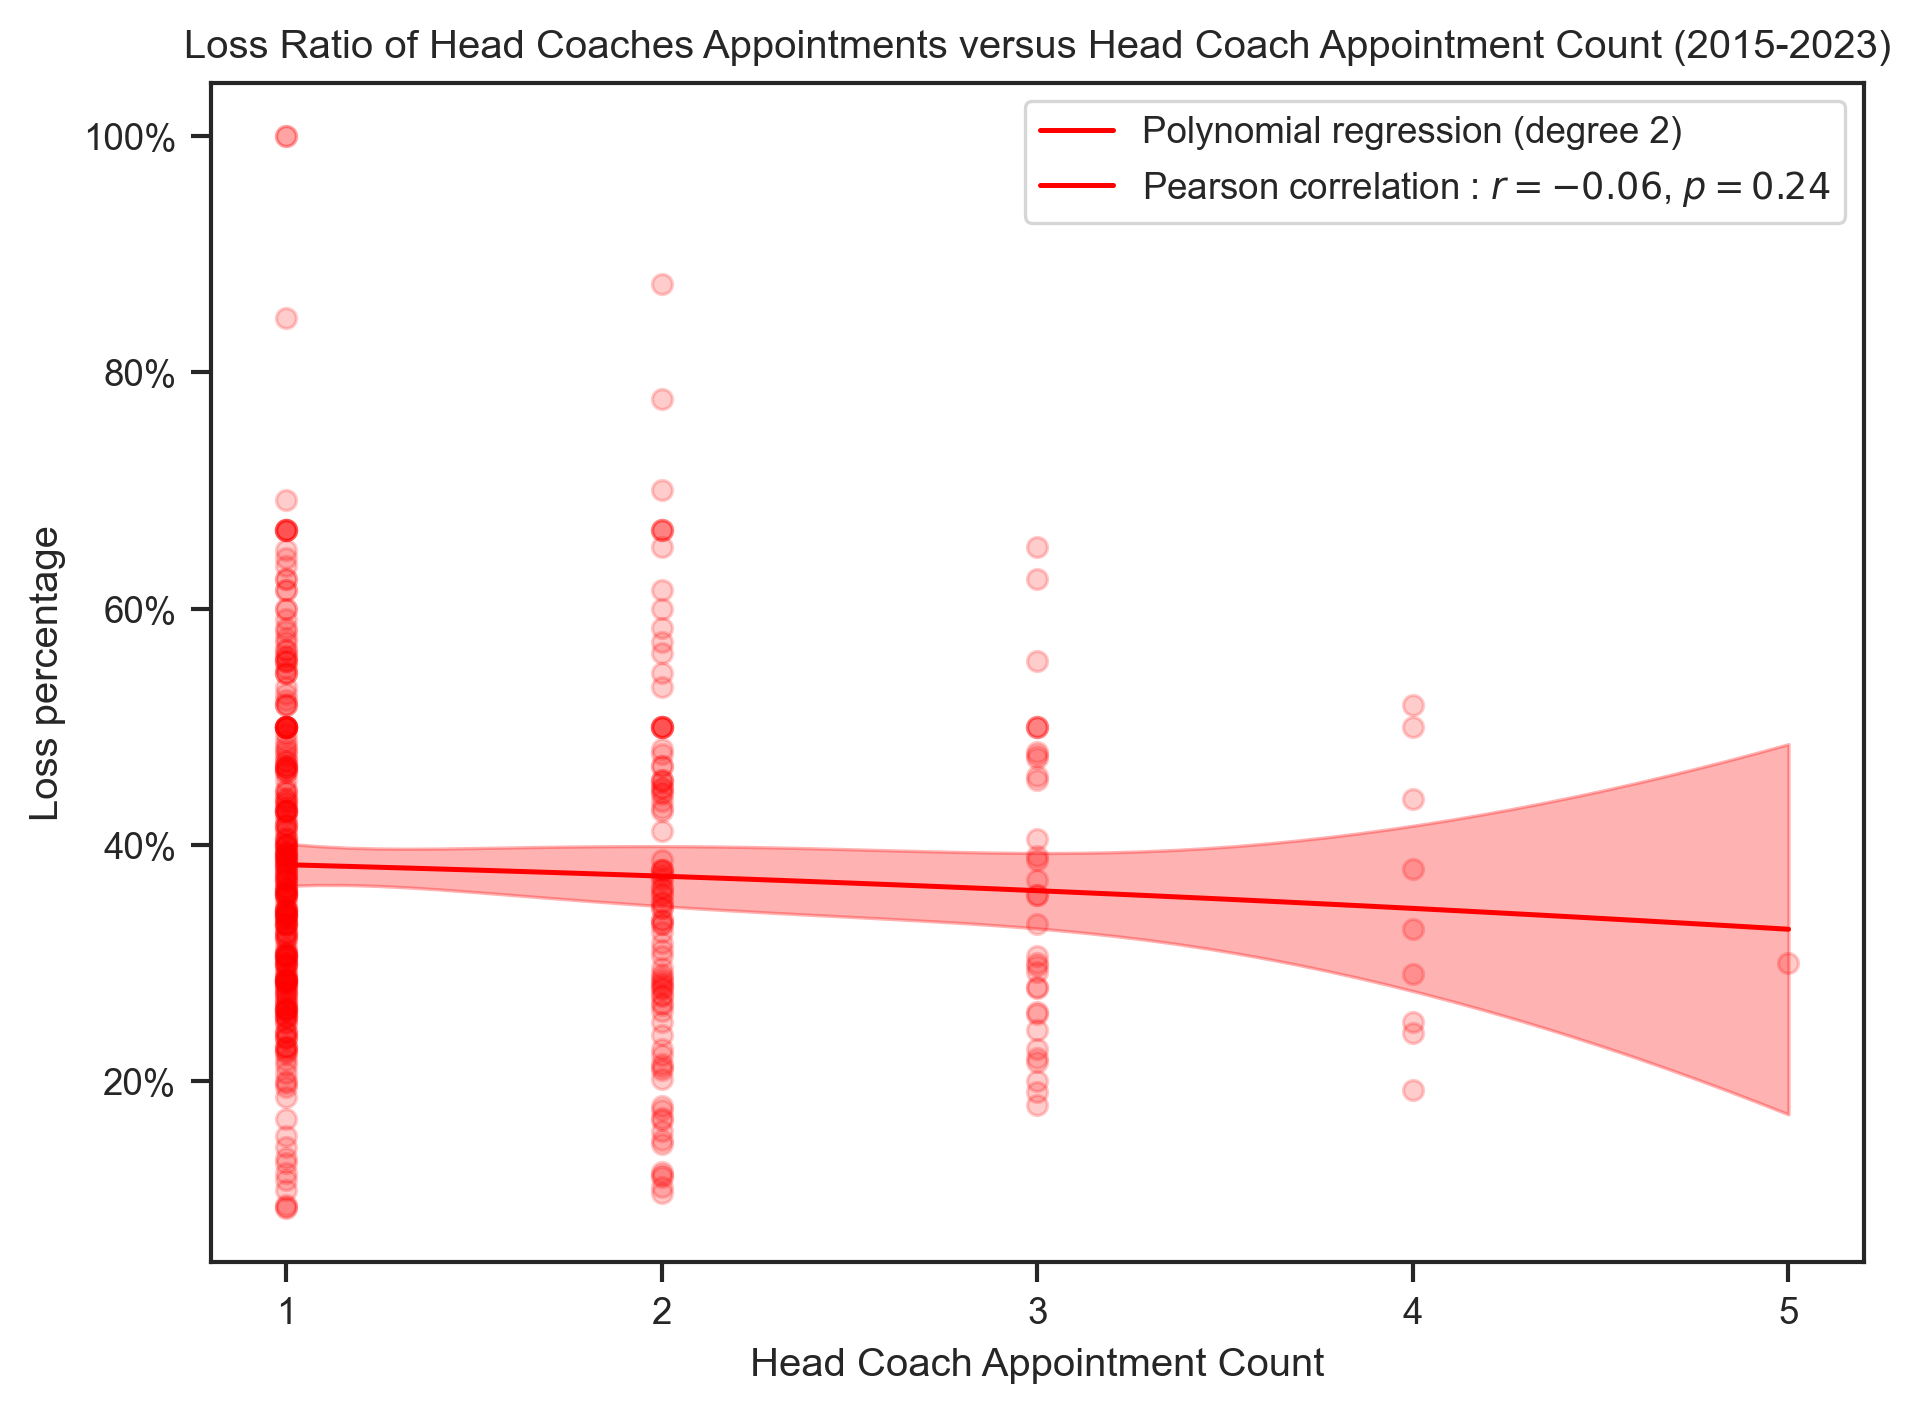

In [21]:
# | label: hc_loss_vs_appointment_count
create_polynomial_regression_plot(
    head_coach,
    "AppointmentNumber",
    "LossPercentage",
    "Loss",
    "red",
    title.format("Loss"),
    x_label,
    degree=2,
    integer_ticks=True,
)

### Loading data

In [22]:
# | label: joint_data
match_results = pl.read_csv(
    Path("./../data/match_results.csv"),
).cast(
    {
        "DaysInPost": pl.Int64,
        "Goals": pl.Int64,
        "Date": pl.Date,
    }
)
match_results.head()

FileNotFoundError: No such file or directory (os error 2): ../data/match_results.csv

### Relation between match outcomes and head coaches days in post during match

In [ ]:
# Exclude rows where don't have information about head coach days in post during match
match_results = match_results.drop_nulls(subset=["DaysInPost"])
# Exclude rows with DaysInPost more than 4000
match_results = match_results.filter(pl.col("DaysInPost") <= 4000)
# The reason for this is that we have records of Arsenal head coach Arsene Wenger who has been in post for 22 years.
# Our data start date for matches is 2015. This makes some matches start with a head coach tenure of 5000 days.

match_results = match_results.with_columns(
    pl.when(pl.col("Result") == "win").then(1).otherwise(0).alias("Win"),
    pl.when(pl.col("Result") == "loss").then(1).otherwise(0).alias("Loss"),
    pl.when(pl.col("Result") == "draw").then(1).otherwise(0).alias("Draw"),
)

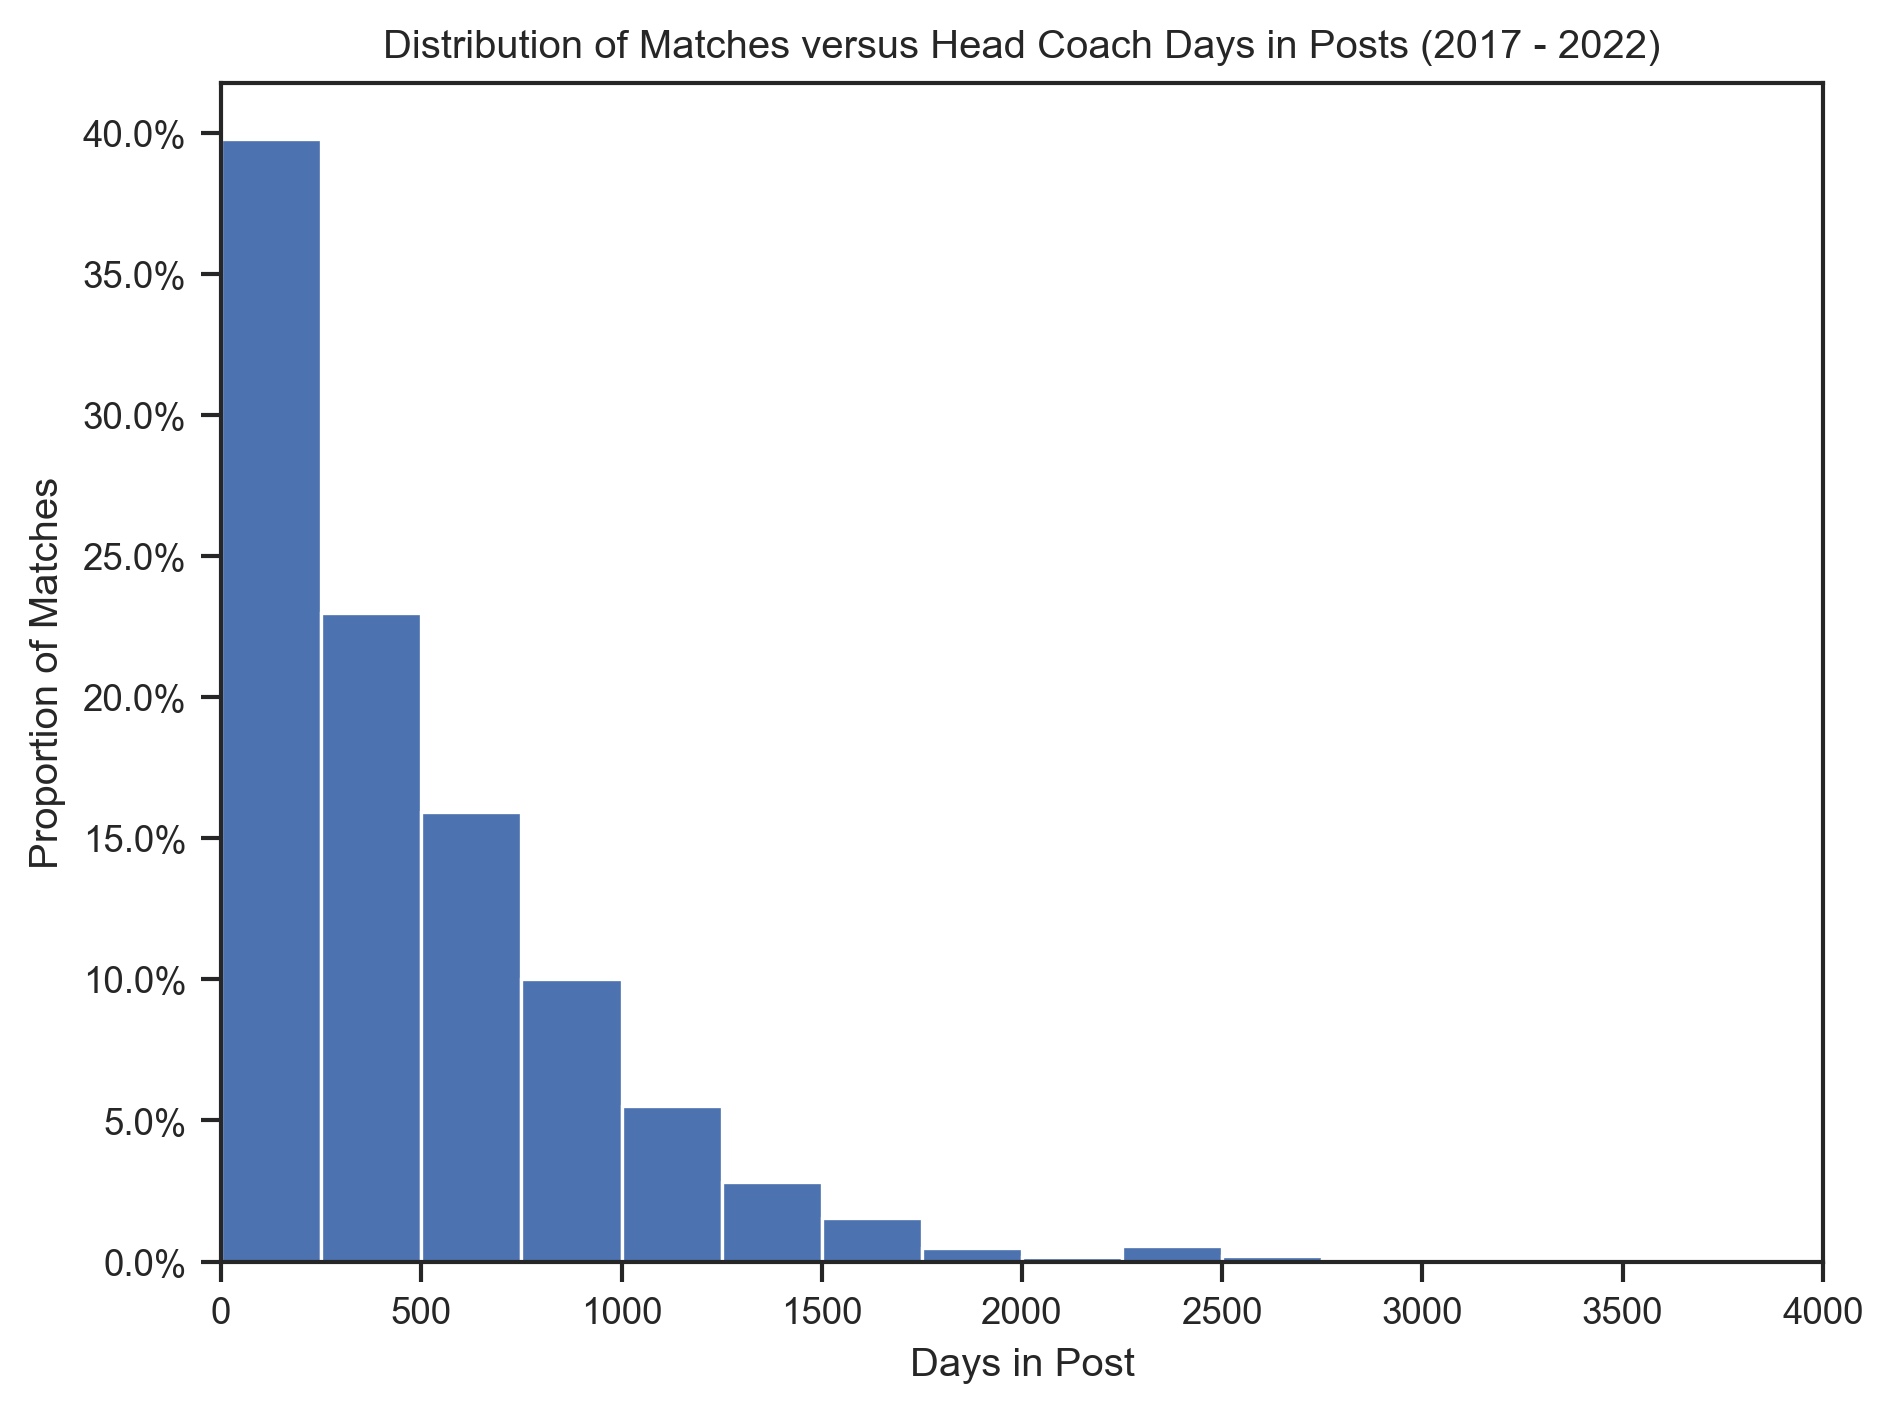

In [ ]:
# | label: match_distribution_over_coach_tenure
# Create a histogram of 'match_count' over 'days_in_post'
plt.figure()
sns.histplot(
    data=match_results,
    x="DaysInPost",
    bins=16,
    stat="proportion",
    binrange=(0, 4000),
    alpha=1,
)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.xlim(0, 4000)
plt.xlabel("Days in Post")
plt.ylabel("Proportion of Matches")
plt.title("Distribution of Matches versus Head Coach Days in Posts (2017 - 2022)")
plt.show()

In [ ]:
def plot_match_outcome_over_coach_tenure(data, y_value, y_label, color):
    # Create a jointplot
    g = sns.jointplot(
        data=data,
        x="DaysInPost",
        y=y_value,
        kind="reg",
        scatter_kws={"alpha": 0.5, "color": color},
        line_kws={"color": color},
        ratio=3,
        marginal_ticks=False,
    )
    g.figure.set_figwidth(6)
    g.figure.set_figheight(2)
    g.figure.suptitle(f"Match outcome over Head Coach Days in Post", x=0.4, y=1.1)
    g.set_axis_labels("Head Coach Days in Post", "Match Outcome")

    # Legend
    days_vals = data.select(pl.col("DaysInPost")).to_numpy().flatten()
    y_vals = data.select(pl.col(y_value)).to_numpy().flatten()
    r, p = pearsonr(days_vals, y_vals)
    legend = g.ax_joint.legend(
        [f"r = {r:.2f}, p = {p:.2f}"], loc="upper left", bbox_to_anchor=(1, 1.6)
    )
    legend.set_title("Pearson correlation")

    # Set y-axis tick
    g.ax_joint.set_yticks([0, 1])
    g.ax_joint.set_yticklabels(["not " + y_label, y_label])

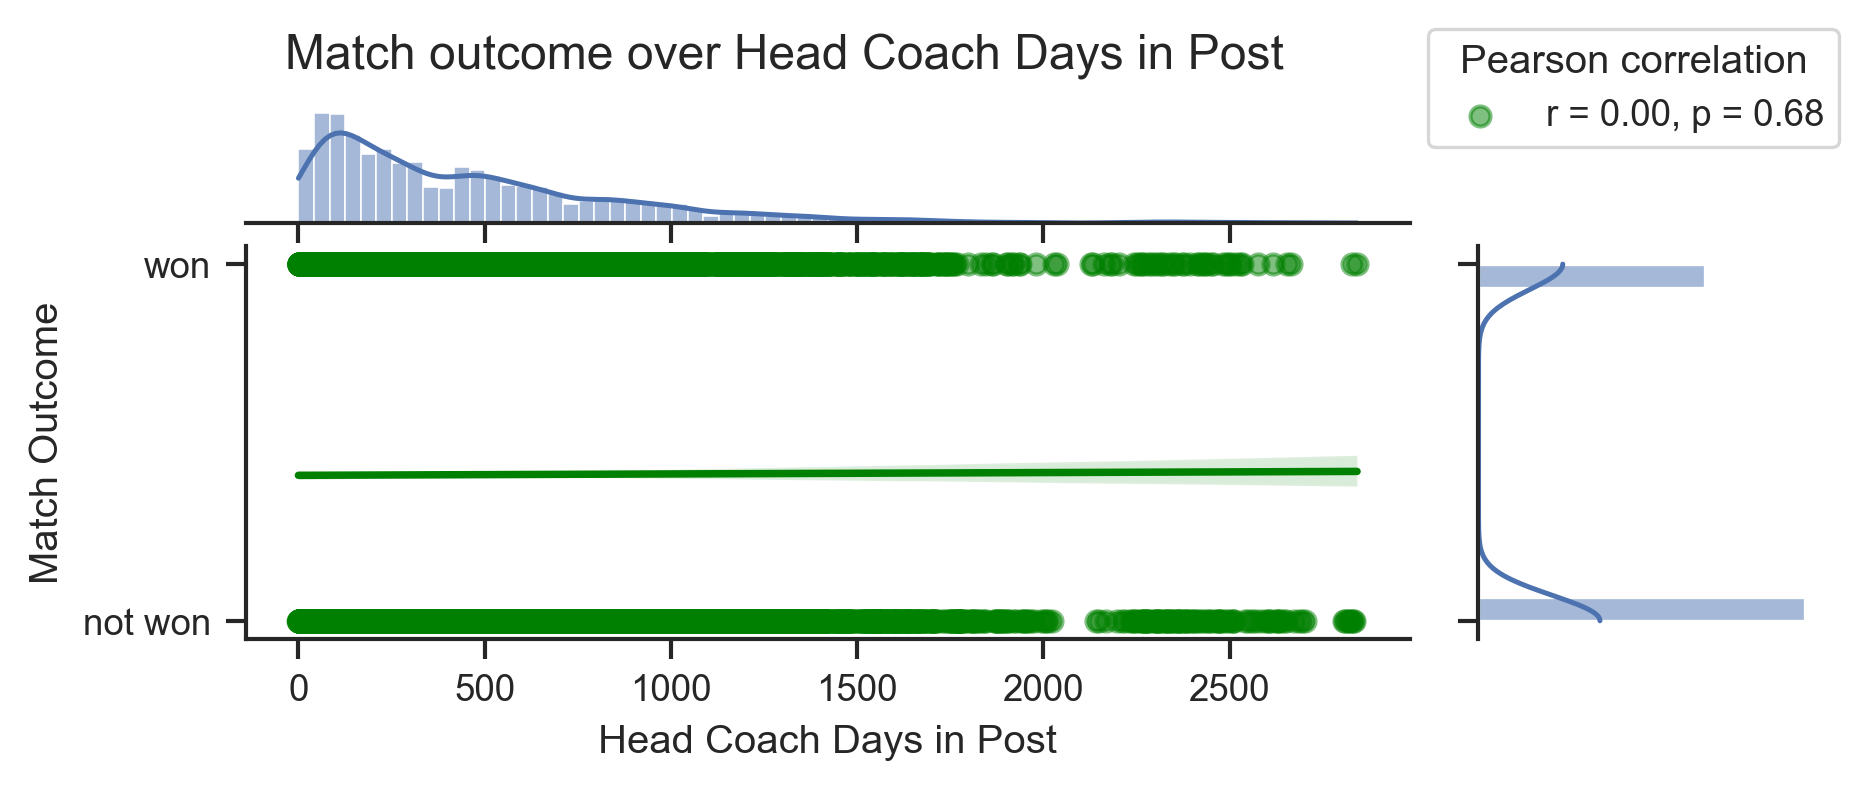

In [ ]:
# | label: win_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, "Win", "won", "green")

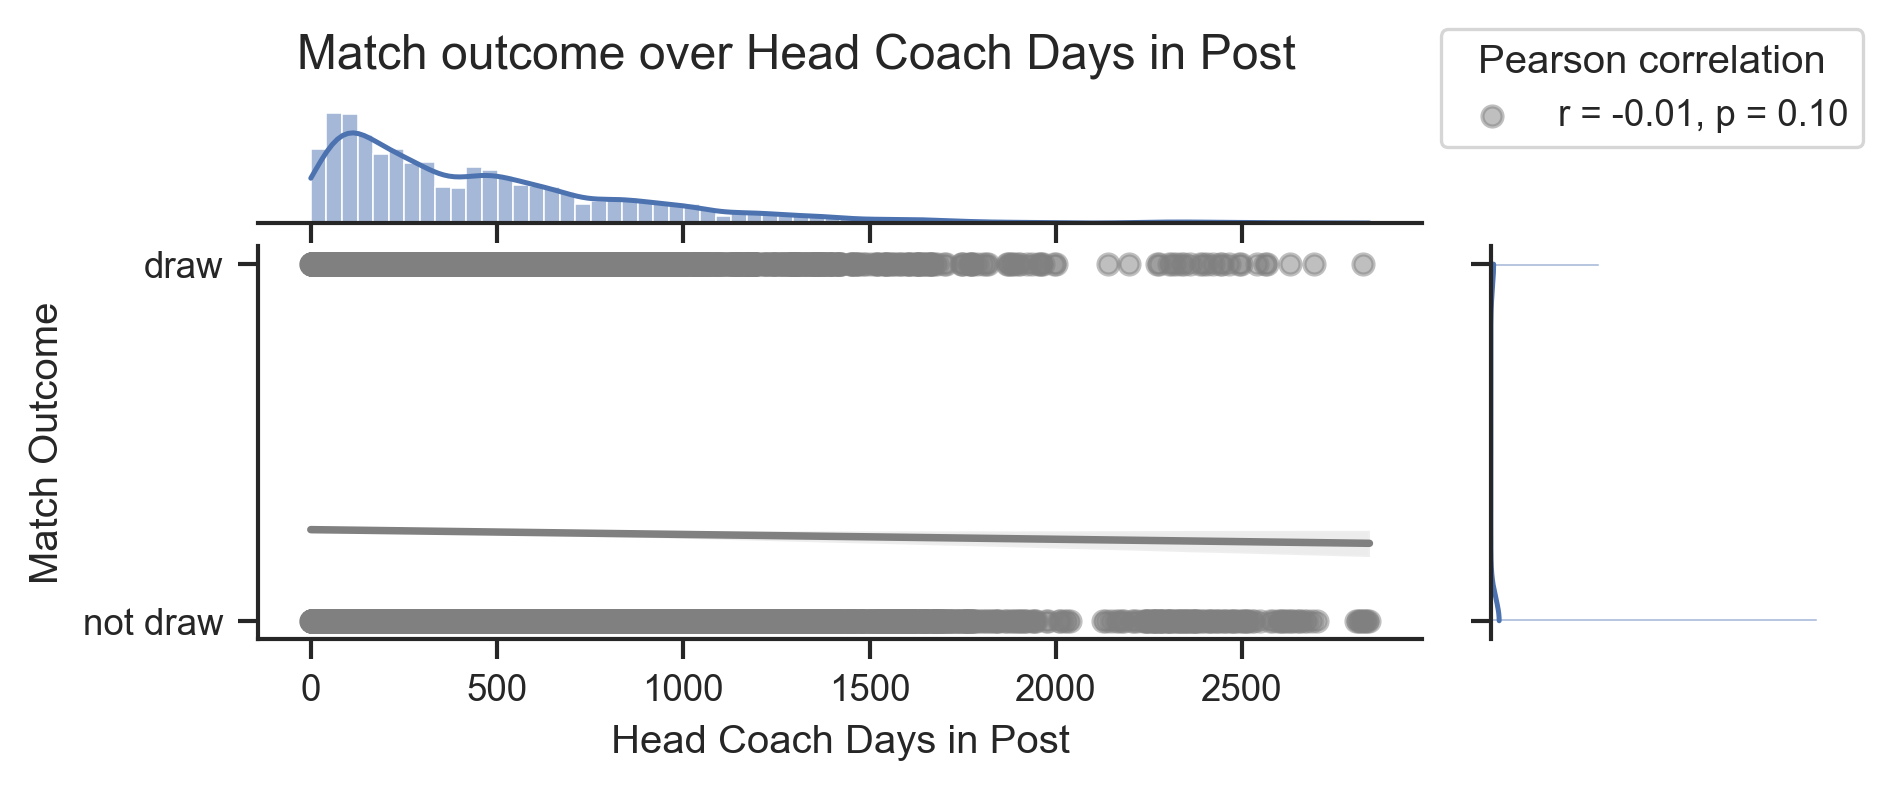

In [ ]:
# | label: draw_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, "Draw", "draw", "gray")

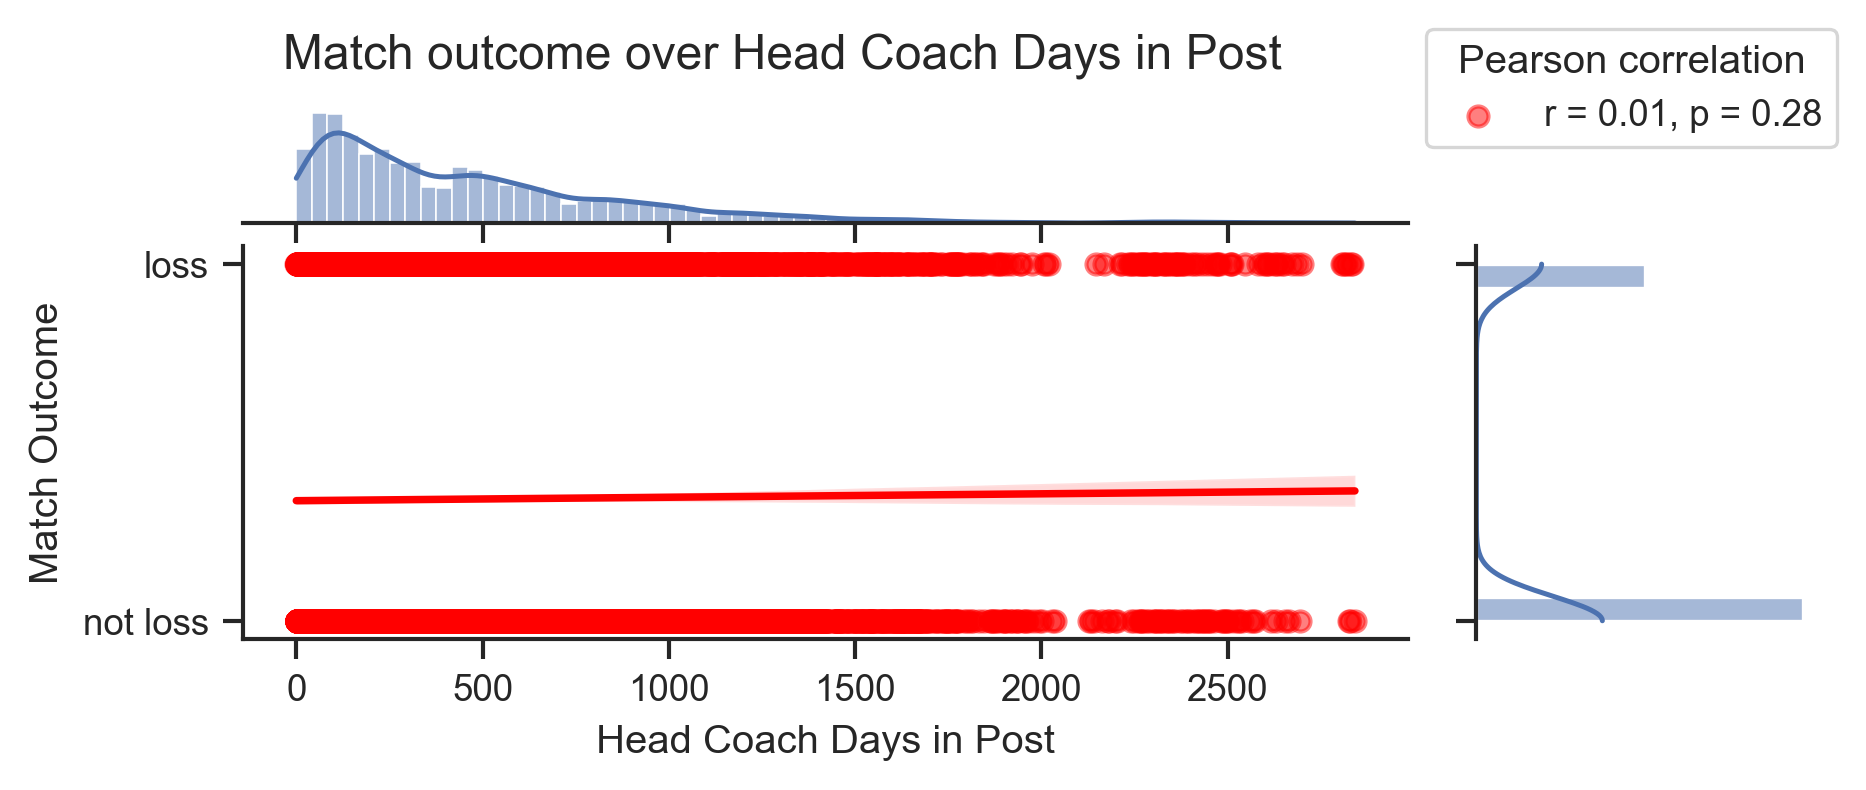

In [ ]:
# | label: loss_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, "Loss", "loss", "red")

In [ ]:
n_match = match_results.height
n_win = match_results.filter(pl.col("Result") == "win").height
n_draw = match_results.filter(pl.col("Result") == "draw").height
n_loss = match_results.filter(pl.col("Result") == "loss").height

Parmi l'ensemble des matchs où l'on possède des informations sur l'entraîneur sportif et où l'entraîneur sportif avait moins de 1500 jours d'ancienneté lors du match :
- le pourcentage de match gagné est de {eval}`f'{n_win/n_match:.2%}'`.
- le pourcentage de match nul est de {eval}`f'{n_draw/n_match:.2%}'`.
- le pourcentage de match perdu est de {eval}`f'{n_loss/n_match:.2%}'`.

In [ ]:
# Create quantile-based groups for more balanced sample sizes
n_quantiles = 10

match_outcomes = (
    match_results.with_columns(
        pl.col("DaysInPost")
        .qcut(n_quantiles, labels=[f"Q{i + 1}" for i in range(n_quantiles)])
        .alias("TenureGroup")
    )
    .group_by("TenureGroup")
    .agg(
        (100 * pl.col("Win", "Draw", "Loss").sum() / pl.len())
        .round(2)
        .name.suffix("Rate"),
        pl.col("DaysInPost").min().alias("MinDaysInPost"),
        pl.col("DaysInPost").max().alias("MaxDaysInPost"),
    )
).sort("MinDaysInPost")

match_outcomes

TenureGroup,WinRate,DrawRate,LossRate,MinDaysInPost,MaxDaysInPost
cat,f64,f64,f64,i64,i64
"""Q1""",38.2,25.79,36.01,0,64
"""Q2""",39.5,23.46,37.04,65,114
"""Q3""",39.42,24.73,35.86,115,174
"""Q4""",40.05,27.81,32.13,175,251
"""Q5""",41.05,25.15,33.81,252,347
"""Q6""",41.4,25.83,32.77,348,472
"""Q7""",44.35,25.03,30.62,473,593
"""Q8""",43.81,22.81,33.38,594,784
"""Q9""",43.52,23.7,32.77,785,1038


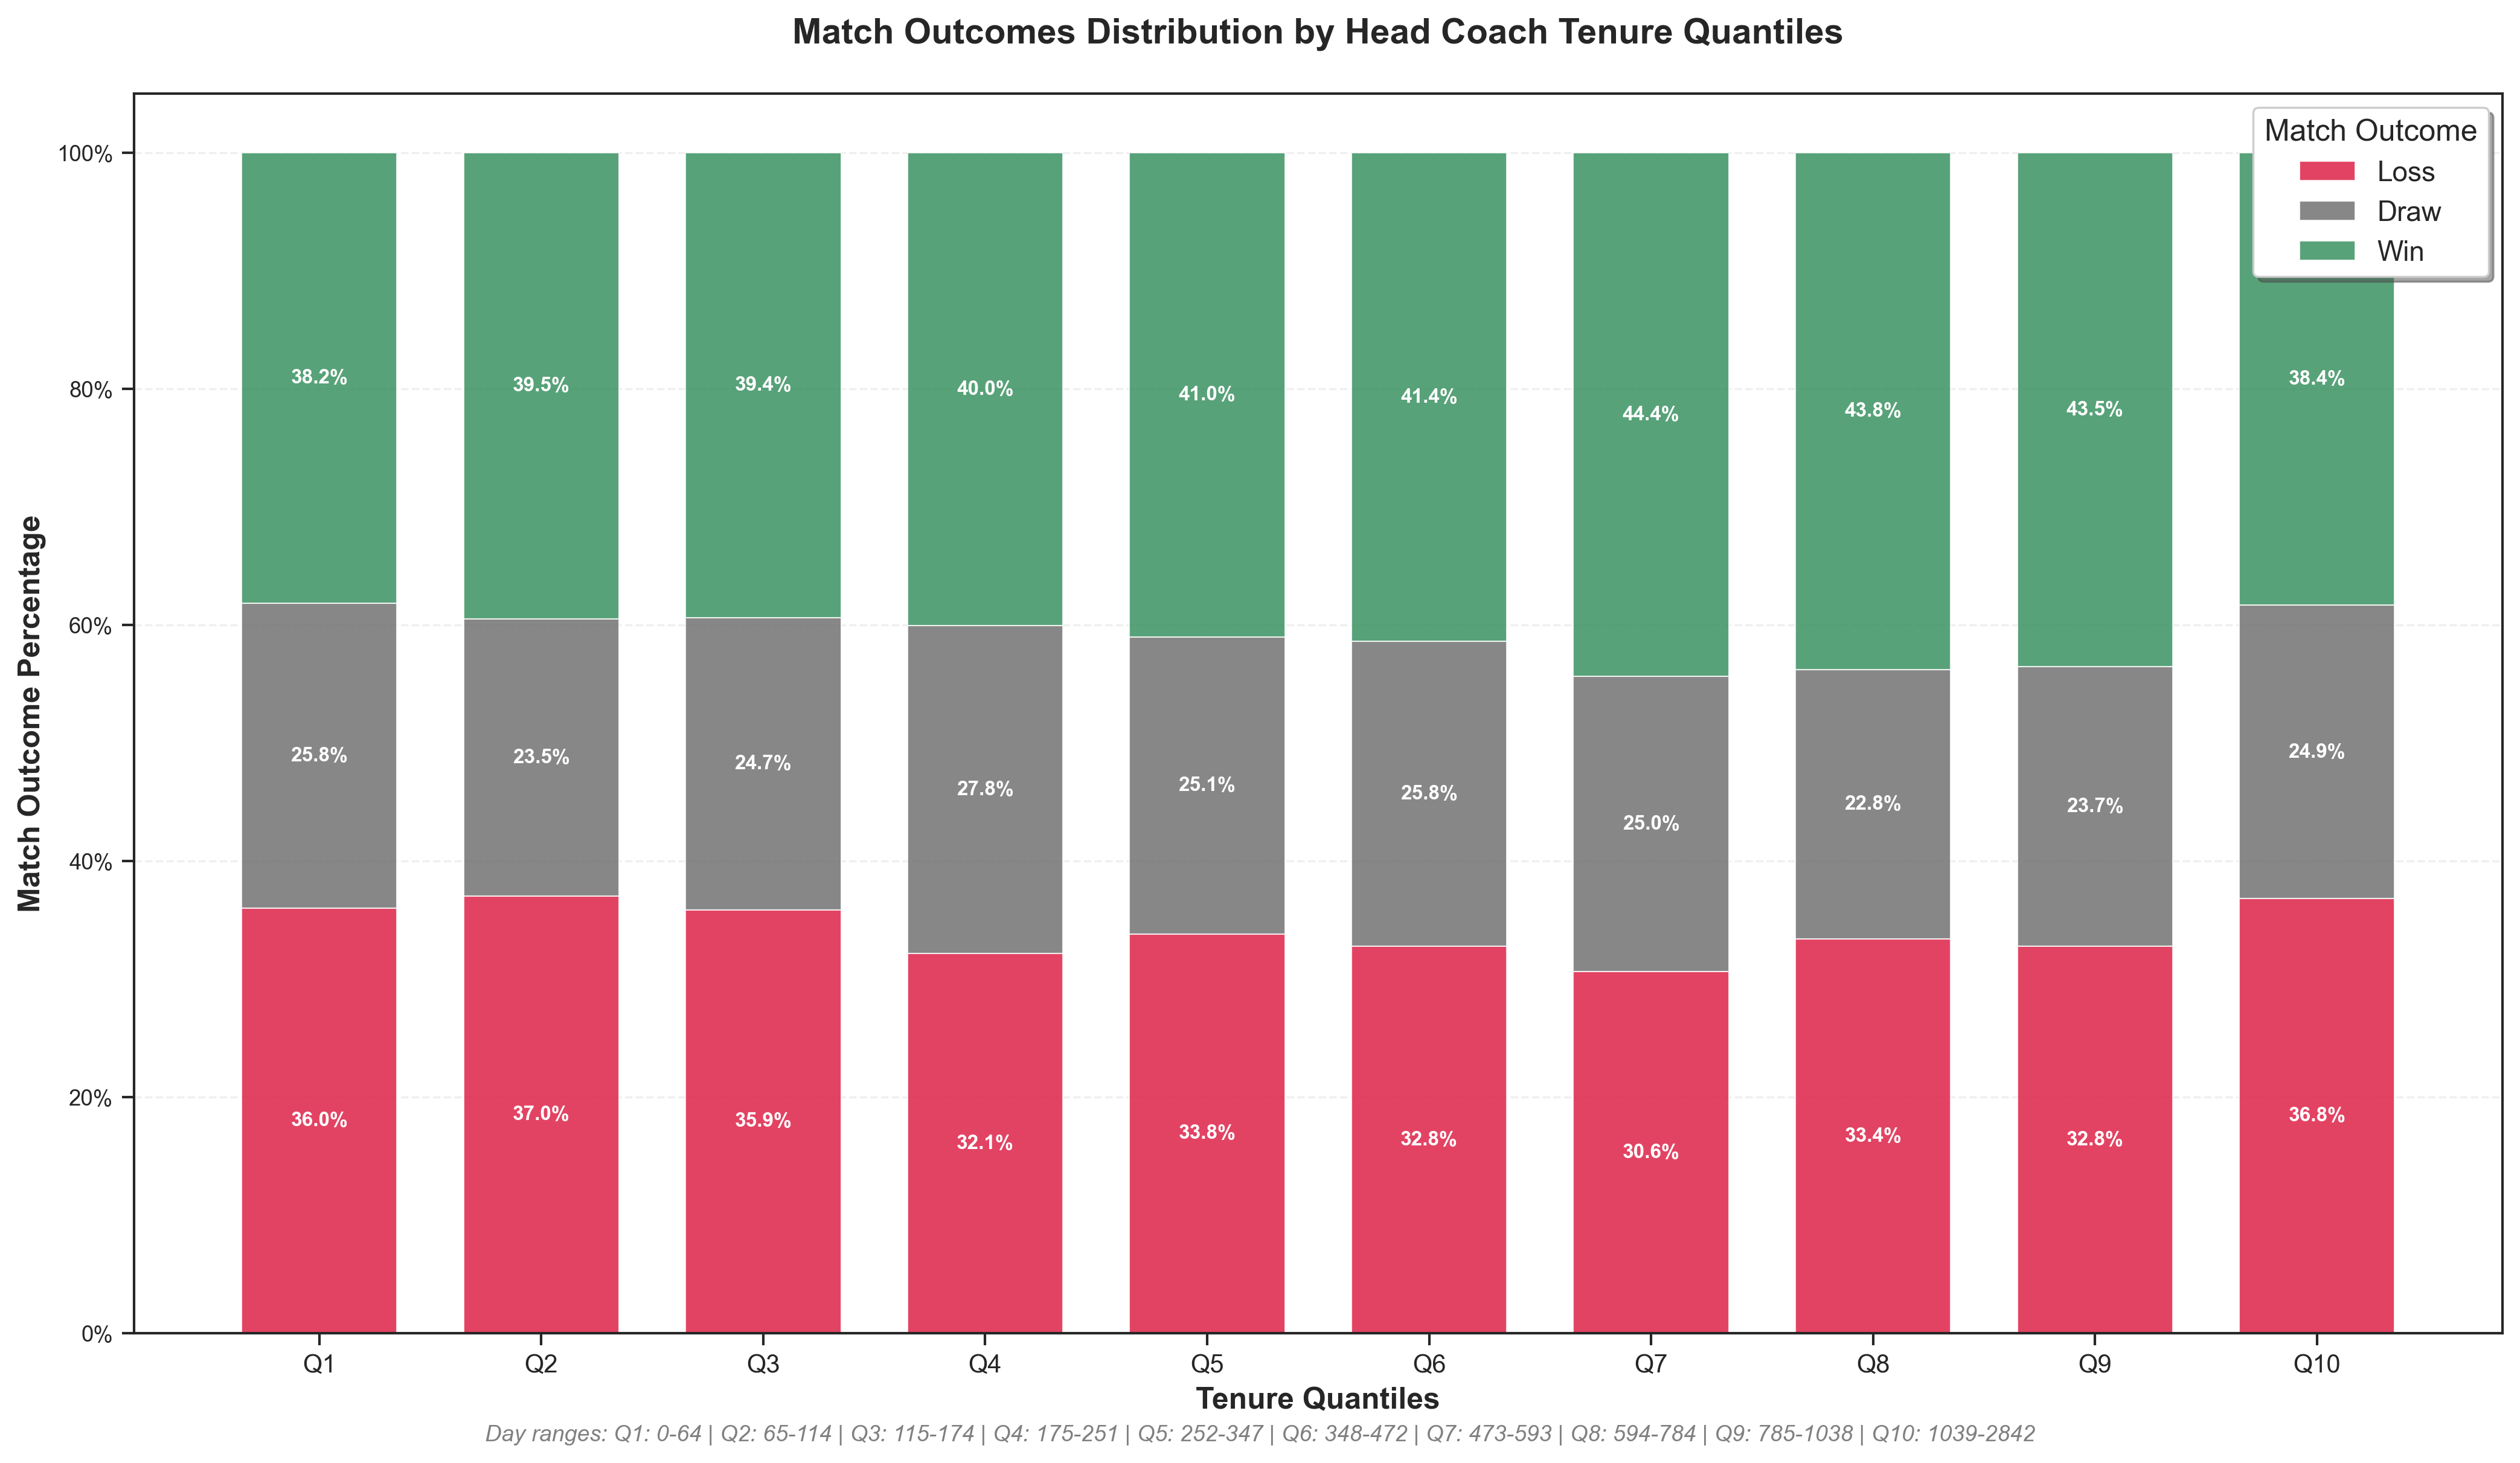

In [ ]:
# | label: match_outcome_over_coach_tenure

# Create the stacked bar chart with improved styling
plt.figure(figsize=(14, 8))

# Define better colors
colors = {
    "win": "#2E8B57",  # Sea green
    "draw": "#696969",  # Dim gray
    "loss": "#DC143C",  # Crimson
}

# Extract the rates for stacking
loss_rates = match_outcomes.get_column("LossRate")
draw_rates = match_outcomes.get_column("DrawRate")
win_rates = match_outcomes.get_column("WinRate")

# Create the stacked bars with improved styling
x_pos = np.arange(len(match_outcomes))
width = 0.7

bars1 = plt.bar(
    x=x_pos,
    height=loss_rates,
    color=colors["loss"],
    alpha=0.8,
    label="Loss",
    width=width,
    edgecolor="white",
    linewidth=0.5,
)
bars2 = plt.bar(
    x=x_pos,
    height=draw_rates,
    bottom=loss_rates,
    color=colors["draw"],
    alpha=0.8,
    label="Draw",
    width=width,
    edgecolor="white",
    linewidth=0.5,
)
bars3 = plt.bar(
    x=x_pos,
    height=win_rates,
    bottom=loss_rates + draw_rates,
    color=colors["win"],
    alpha=0.8,
    label="Win",
    width=width,
    edgecolor="white",
    linewidth=0.5,
)

# Customize the plot with better styling
plt.xlabel("Tenure Quantiles", fontsize=12, fontweight="bold")
plt.ylabel("Match Outcome Percentage", fontsize=12, fontweight="bold")
plt.title(
    "Match Outcomes Distribution by Head Coach Tenure Quantiles",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

# Improved x-axis labels
quantile_labels = [f"Q{i + 1}" for i in range(n_quantiles)]
plt.xticks(x_pos, quantile_labels, fontsize=10)

# Enhanced legend
plt.legend(
    loc="upper right",
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=11,
    title="Match Outcome",
    title_fontsize=12,
)

# Improved formatting
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.ylim(0, 105)  # Add some space at the top

# Add value labels on bars for better readability
for i, (loss, draw, win) in enumerate(zip(loss_rates, draw_rates, win_rates)):
    # Only show values if they're significant enough
    if loss > 5:
        plt.text(
            i,
            loss / 2,
            f"{loss:.1f}%",
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=8,
            color="white",
        )
    if draw > 5:
        plt.text(
            i,
            loss + draw / 2,
            f"{draw:.1f}%",
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=8,
            color="white",
        )
    if win > 5:
        plt.text(
            i,
            loss + draw + win / 2,
            f"{win:.1f}%",
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=8,
            color="white",
        )

plt.tight_layout()

# Add subtitle with day ranges in a more elegant way
subtitle_text = "Day ranges: " + " | ".join(
    [
        f"Q{i + 1}: {row['MinDaysInPost']}-{row['MaxDaysInPost']}"
        for i, row in enumerate(match_outcomes.to_dicts())
    ]
)
plt.figtext(
    0.5, -0.0, subtitle_text, ha="center", fontsize=9, style="italic", color="gray"
)

plt.show()